## NOTES:
<ul>
<li>This notebook allows for further analysis of a single site and single metric from the dataset produced by aquifer analysis</li>
<li>The purpose is primarily for data visualization as well as deeper exploration into sites of interest. It is also for data validation. Additionally, this notebook gives more insight into what each metric is measuring and what each column of the aquifer analysis data sets represent</li><br>
<li>Each metric can be run independently of any others and are calculated using the same methods as in the aquifer analysis</li>
<li>As such, each metric is calculated independently here rather than relying on any data from any previous cells to ensure reliability</li>
<li>Furthermore, each visual is produced using the raw data, rather than the results of the calculations so that conclusions can be drawn on whether or not the visualization matches with the calculations</li>
</ul>

## CORE: Imports and Controls

In [157]:
# Imports -- Python 3.10
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

from matplotlib import ticker
from importlib import reload
from dataretrieval import nwis
from datetime import timedelta

# Custom libs
import Src.func_ko as fn
import Src.classes as cl
reload(fn)
reload(cl)

pd.options.mode.chained_assignment = None

from matplotlib.dates import MonthLocator, DateFormatter # for plotting month on x-axis
import matplotlib.dates as mdates

In [202]:
# Controls
# '11447650' -- SRB
# '11303500' -- SJB
# '03575830' -- testsite
site_no = '11447650'

K_DEFAULT_START = '1900-10-01'
K_DEFAULT_END = '2015-09-30' # end date for Kocis paper

DEFAULT_START = '1900-10-01'
DEFAULT_END = '2020-09-30' # end date for this study
df = nwis.get_record(sites=site_no, service=fn.SERVICE, parameterCD=fn.PARAM_CODE, start=K_DEFAULT_START, end=K_DEFAULT_END)

if site_no == '11447650':
    df1 = nwis.get_record(sites=str(site_no), service=fn.SERVICE, start=K_DEFAULT_START, end =K_DEFAULT_END, parameterCd='00060')
    df2 = nwis.get_record(sites=str(site_no), service=fn.SERVICE, start='2015-09-01', end=DEFAULT_END, parameterCd='72137')
    df = pd.concat([df1, df2])
    df.loc[df['00060_Mean'].isna(), '00060_Mean'] = df.loc[df['00060_Mean'].isna(), '72137_Mean']

# Aquifer analysis is done on both 30 and 50-year periods with both 90 and 95% quantiles
data_range = 30 
quantile = 0.90

## METRIC: Valid
The `valid` column indicates whether a given site is missing no more than `MAX_MISSING_THRESHOLD` percent of its data across the analyzed range. For the purposes of this study `MAX_MISSING_THRESHOLD` is set to 10%.

Valid: True -- Missing 0.0000%


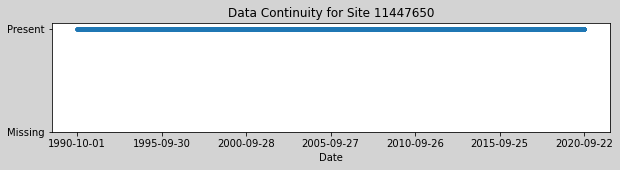

In [203]:
df_valid = df.reset_index()

# Trim the dataset to just the current analyzed date range (end date - data_range)
# Set all present values to 1
start = pd.to_datetime(DEFAULT_END).date() - timedelta(days=365.25 * data_range)
df_valid = df_valid[df_valid['datetime'].dt.date >= start]
df_valid['00060_Mean'] = 1 

# Validation using the predetermined start and end dates of (1970/90-2020)
missing = fn.validate(df_valid, start, DEFAULT_END)
print(f"Valid: {missing < fn.MAX_MISSING_THRESHOLD} -- Missing {missing * 100:.4f}%")

# Create missing dates and set their values to 0
complete_range = pd.date_range(start=start, end=DEFAULT_END, freq='D')
df_complete = pd.DataFrame({'datetime': complete_range})
df_valid = pd.concat([df_complete.set_index('datetime').tz_localize(None), df_valid.set_index('datetime').tz_localize(None)], axis=1, join='outer').fillna(0).reset_index()

plt.figure(figsize=(10, 2), facecolor='lightgray')
plt.plot(df_valid['datetime'], df_valid['00060_Mean'], marker='.', linestyle='dotted')

plt.yticks([0, 1], ['Missing', 'Present'])
plt.xticks(df_valid['datetime'][::(365*5)])
plt.xlabel("Date")

plt.title(f"Data Continuity for Site {site_no}")
plt.show()

## METRIC: Threshold
The `threshold` value is the flow value (ft<sup>3</sup>/s) above which any excess flow is considered high magnitude flow (HMF). This value is calculated as some quantile, 90% and 95% in the case of this study, of the total streamflow.

Threshold: 52600.0


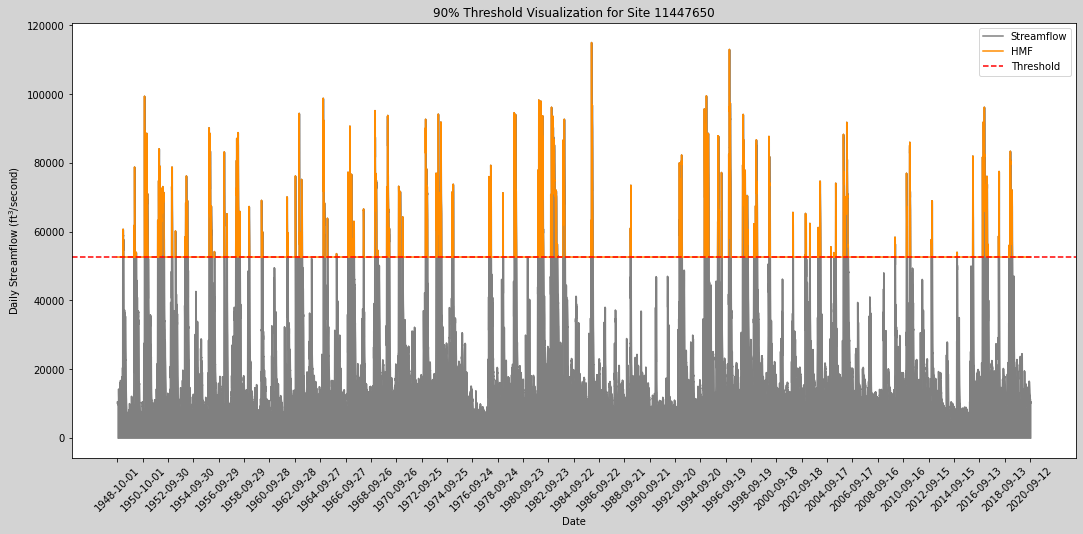

In [204]:
df_threshold = df.reset_index()

#start = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * data_range)
#df_threshold = df_threshold[df_threshold['datetime'].dt.date >= start]


threshold = fn.calc_threshold(df_threshold, quantile)
print(f"Threshold: {threshold}")

df_threshold["diff"] = df_threshold["00060_Mean"] - threshold
df_threshold["hmf"] = df_threshold["diff"].apply(lambda x: max(0, x))

'''window = 50
df_threshold["00060_Mean"] = df_threshold["00060_Mean"].rolling(window=window).mean()
df_threshold["hmf"] = df_threshold["hmf"].rolling(window=window).mean()'''

plt.figure(figsize=(18, 8), facecolor='lightgray')
plt.plot(df_threshold["datetime"], df_threshold["00060_Mean"], label="Streamflow", color="gray")
plt.plot(df_threshold["datetime"], threshold+df_threshold["hmf"], label="HMF", color="darkorange")
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')

plt.fill_between(df_threshold["datetime"], df_threshold["00060_Mean"], color="gray")
#plt.fill_between(df_threshold["datetime"], df_threshold["hmf"], color="orange")

plt.xticks(df_threshold['datetime'][::(365*2)], rotation=45)
plt.xlabel("Date")

plt.ylabel('Daily Streamflow ($\mathregular{ft^3}$/second)')

plt.title(f"{quantile*100:.0f}% Threshold Visualization for Site {site_no}")
plt.legend()
plt.show()

### Plot for streamflow over selected time period

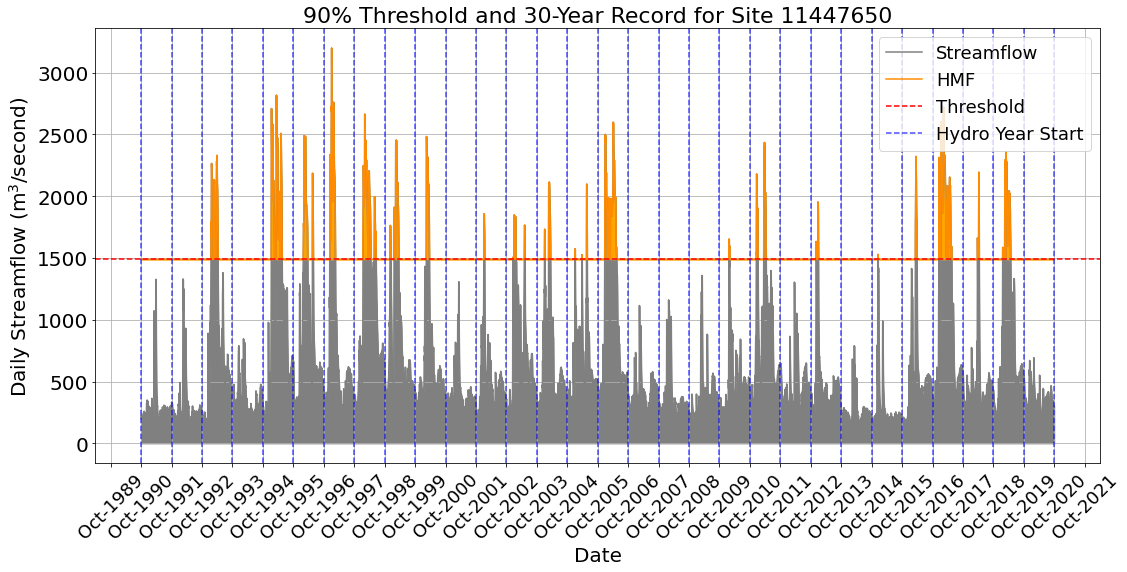

In [205]:
PLOT_START = '1990-10-01'
PLOT_END = '2020-10-01'
CFS_TO_CMS = 0.028316846592

def streamflow_timeseries(df, PLOT_START, PLOT_END, save=False):
    df_plot = df.reset_index()
    
    threshold = fn.calc_threshold(df_plot, quantile)

    threshold_cms = threshold * CFS_TO_CMS
    df_plot['00060_Mean_cms'] = df_plot["00060_Mean"] * CFS_TO_CMS

    df_plot["diff_cms"] = df_plot["00060_Mean_cms"] - threshold_cms
    df_plot["hmf_cms"] = df_plot["diff_cms"].apply(lambda x: max(0, x))

    # Select certain dates to plot
    df_plot = df_plot.loc[(df_plot['datetime'] >= PLOT_START) & (df_plot['datetime'] <= PLOT_END)]

    '''window = 50
    df_threshold["00060_Mean"] = df_threshold["00060_Mean"].rolling(window=window).mean()
    df_threshold["hmf"] = df_threshold["hmf"].rolling(window=window).mean()'''

    plt.figure(figsize=(18, 8))

    plt.plot(df_plot["datetime"], df_plot["00060_Mean_cms"], label="Streamflow", color="gray")
    plt.plot(df_plot["datetime"], threshold_cms+df_plot["hmf_cms"], label="HMF", color="darkorange")
    plt.axhline(y=threshold_cms, color='r', linestyle='--', label='Threshold')

    plt.fill_between(df_plot["datetime"], df_plot["00060_Mean_cms"], color="gray")
    plt.fill_between(df_plot["datetime"], y1=threshold_cms, y2=threshold_cms+df_plot["hmf_cms"], color="orange")

    # Plot vertical lines to separate water years
    first = True
    for year in range(df_plot["datetime"].dt.year.min(), df_plot["datetime"].dt.year.max() + 1):
        oct1 = pd.to_datetime(f'{year}-10-01')
        if first:
            plt.axvline(oct1, color='blue', linestyle='--', alpha=0.7, label='Hydro Year Start')
            first = False
        else:
            plt.axvline(oct1, color='blue', linestyle='--', alpha=0.7) 

    # Plot month names instead of numerical dates
    plt.gca().xaxis.set_major_locator(MonthLocator(bymonth=10))
    plt.gca().xaxis.set_major_formatter(DateFormatter('%b-%Y'))  # %b for month abbreviation
    plt.xticks(rotation=45, fontsize=18)
    plt.xlabel("Date", fontsize=20)

    plt.yticks(fontsize=20)
    plt.ylabel('Daily Streamflow ($\mathregular{m^3}$/second)', fontsize=20)

    plt.title(f"{quantile*100:.0f}% Threshold and 30-Year Record for Site {site_no}", fontsize=22)
    #plt.title(f"{quantile*100:.0f}% Threshold Visualization for Site {site_no}", fontsize=22)
    plt.grid(True)
    plt.legend(fontsize=18, loc=1)

    if save == True:
        plt.savefig(f'Saved_Visuals/hyd201b_presentation/30_year_rec_timeseries_{site_no}.png', bbox_inches='tight')

    plt.show()
    
streamflow_timeseries(df, PLOT_START, PLOT_END, True)

## METRIC: HMF Years, Inter-Annual Frequency
The `hmf_years` column tracks the total number of hydrologic years over the analyzed range that saw any amount of HMF. `inter_annual` tracks the frequency with which years experience at least one HMF event.

HMF Years: 20
Inter-Annual: 0.6666666666666666
Delta: 30, 29.998631074606433, 30
Min: 1990 Max: 2020


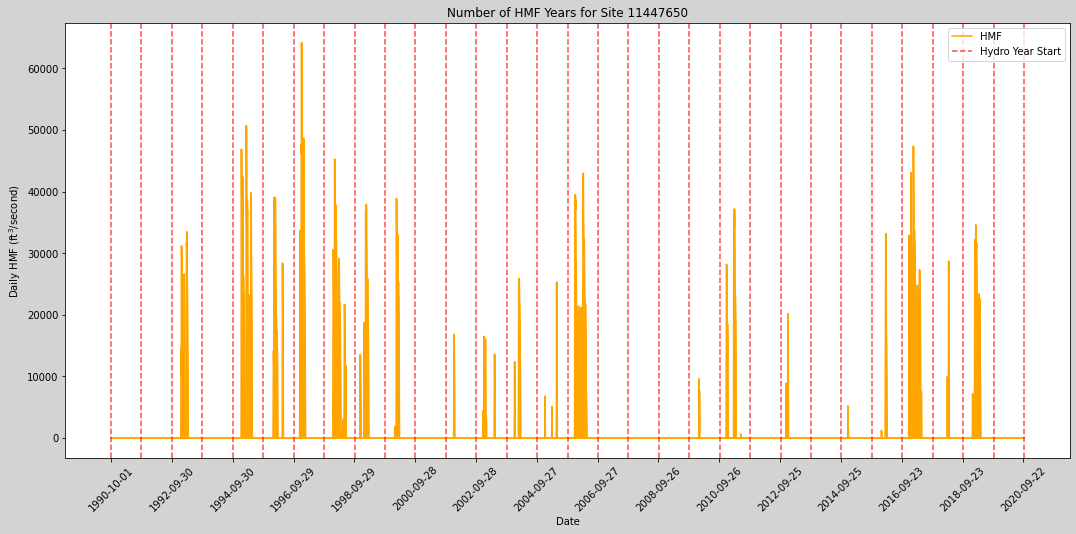

In [206]:
df_threshold = df.reset_index()

start = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * data_range)
df_threshold = df_threshold[df_threshold['datetime'].dt.date >= start]

threshold = fn.calc_threshold(df_threshold, quantile)
hmf_series_defl, hmf_series_cont = fn.filter_hmf(df_threshold, threshold)
hmf_years = fn.num_hmf_years(hmf_series_defl)
print(f"HMF Years: {hmf_years}")
delta = (hmf_series_cont["datetime"].max() - hmf_series_cont["datetime"].min()).days / 365.25
record_years = hmf_series_cont['datetime'].dt.year.nunique()-1
print(f"Inter-Annual: {hmf_years / record_years}")
print(f'Delta: {math.ceil(delta)}, {delta}, {record_years}')
print(f'Min: {hmf_series_cont["datetime"].min().year} Max: {hmf_series_cont["datetime"].max().year}')

df_threshold["diff"] = df_threshold["00060_Mean"] - threshold
df_threshold["hmf"] = df_threshold["diff"].apply(lambda x: max(0, x))

plt.figure(figsize=(18, 8), facecolor='lightgray')
plt.plot(df_threshold["datetime"], df_threshold["hmf"], label="HMF", color="orange")

first = True
for year in range(df_threshold["datetime"].dt.year.min(), df_threshold["datetime"].dt.year.max() + 1):
    oct1 = pd.to_datetime(f'{year}-10-01')

    if first:
        plt.axvline(oct1, color='red', linestyle='--', alpha=0.7, label='Hydro Year Start')
        first = False
    else:
        plt.axvline(oct1, color='red', linestyle='--', alpha=0.7)        

plt.fill_between(df_threshold["datetime"], df_threshold["hmf"], color="orange")

plt.xticks(df_threshold['datetime'][::(365*2)], rotation=45)
plt.xlabel("Date")

plt.ylabel('Daily HMF ($\mathregular{ft^3}$/second)')

plt.title(f"Number of HMF Years for Site {site_no}")
plt.legend()
plt.show()

## METRIC: Annual HMF
The `annual_hmf` column holds the average amount of HMF, in km<sup>3</sup> per year.

Annual HMF: 1.75 km^3/year


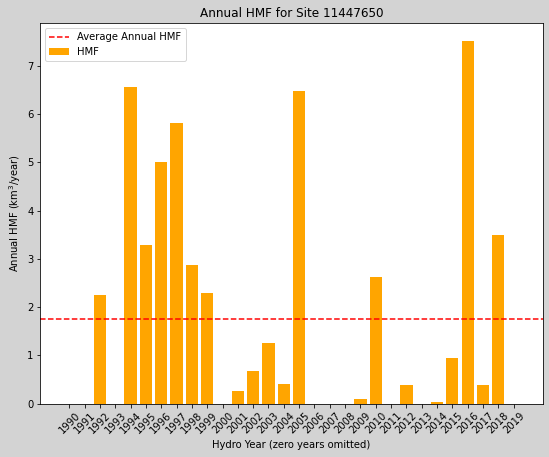

In [207]:
df_annualhmf = df.reset_index()

start = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * data_range)
df_annualhmf = df_annualhmf[df_annualhmf['datetime'].dt.date >= start]

threshold = fn.calc_threshold(df_annualhmf, quantile)
hmf_series, hmf_series_cont = fn.filter_hmf(df_annualhmf, threshold)
hmf_years = fn.num_hmf_years(hmf_series_cont)
hmf_series_cont = fn.convert_hmf(hmf_series_cont, threshold)

hmf_series_cont = hmf_series_cont.reset_index()
hmf_series_cont['datetime'] = pd.to_datetime(hmf_series_cont['datetime'])
hmf_series_cont.set_index('datetime', inplace=True)

annual_sum = hmf_series_cont['00060_Mean'].resample(fn.HYDRO_YEAR).sum()
#print(len(annual_sum))
annual_sum = annual_sum * fn.CUBIC_FT_KM_FACTOR
annual_hmf = annual_sum.sum() / hmf_years
print(f"Annual HMF: {annual_hmf:.2f} km^3/year")

# Filtering out 0 years since average is calculated using only non-zero years
# and this will make the visualization more accurate
#annual_sum = annual_sum[annual_sum > 0]

fig = plt.figure(figsize=(9, 7), facecolor='lightgray')
plt.bar(range(len(annual_sum.index)), annual_sum, color='orange')
plt.axhline(y=annual_hmf, color='r', linestyle='--')

plt.xlabel('Hydro Year (zero years omitted)')
plt.xticks(range(len(annual_sum.index)), annual_sum.index.strftime('%Y'), rotation=45)
plt.ylabel('Annual HMF ($\mathregular{km^3}$/year)')

plt.title(f'Annual HMF for Site {site_no}')
plt.legend(['Average Annual HMF', 'HMF'])
plt.show()

## METRIC: 3 and 6 Month HMF
The `three_mo_hmf` and `six_mo_hmf` columns indicate the HMF (in km<sup>3</sup>/year) over a selected 3-month and 6-month window of the wettest months of the hydrologic year. The default 3-month window is from Dec-Feb, while the 6-month window is Nov-Apr.

In [208]:
# Window selection by month
three_start = 12
three_end = 2
six_start = 11
six_end = 4

# Window to view for first plot (visualization is too busy with windows larger than one year)
window_start = pd.Timestamp('1994-10-01')
window_end = pd.Timestamp(window_start + pd.DateOffset(days=365))

6 Month HMF: 2.44 -- 92.72% of Total HMF
3 Month HMF: 1.37 -- 52.16% of Total HMF


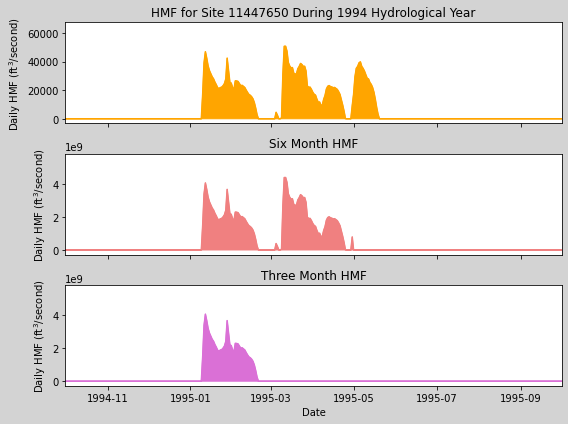

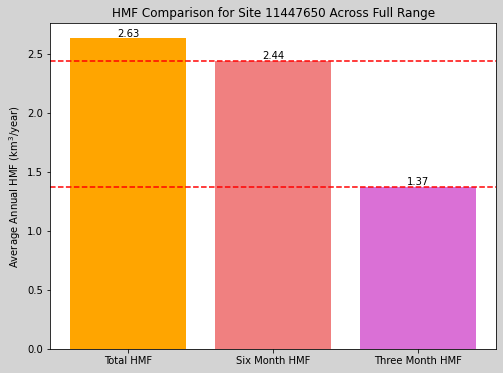

In [165]:
df_threesix = df.reset_index()

start = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * data_range)
df_threesix = df_threesix[df_threesix['datetime'].dt.date >= start]

threshold = fn.calc_threshold(df_threesix, quantile)
hmf_series, _ = fn.filter_hmf(df_threesix, threshold)
hmf_years = fn.num_hmf_years(hmf_series)

df_six_mo, df_three_mo = fn.three_six_range(hmf_series, three_start, three_end, six_start, six_end)

# For final report 
hmf_series = fn.convert_hmf(hmf_series, threshold)
hmf_series = hmf_series.reset_index(drop=True)
total_hmf_flow = (hmf_series["00060_Mean"].sum() * fn.CUBIC_FT_KM_FACTOR) / hmf_years

df_six_mo = fn.convert_hmf(df_six_mo, threshold)
df_six_mo = df_six_mo.reset_index(drop=True)
six_mo_hmf = (df_six_mo["00060_Mean"].sum() * fn.CUBIC_FT_KM_FACTOR) / hmf_years

df_three_mo = fn.convert_hmf(df_three_mo, threshold)
df_three_mo = df_three_mo.reset_index(drop=True) 
three_mo_hmf = (df_three_mo["00060_Mean"].sum() * fn.CUBIC_FT_KM_FACTOR) / hmf_years  

# Calculate the percentage of each HMF value compared to the total HMF flow
total_hmf_percentage = total_hmf_flow / total_hmf_flow * 100
six_mo_hmf_percentage = six_mo_hmf / total_hmf_flow * 100
three_mo_hmf_percentage = three_mo_hmf / total_hmf_flow * 100

print(f"6 Month HMF: {six_mo_hmf:.2f} -- {six_mo_hmf_percentage:.2f}% of Total HMF")
print(f"3 Month HMF: {three_mo_hmf:.2f} -- {three_mo_hmf_percentage:.2f}% of Total HMF")

# The following is all for plotting purposes and does not occur in Aquifer Analysis
# Fill missing datetime values with 0's for plotting
df_six_mo.drop(columns=['index'], inplace=True)
df_three_mo.drop(columns=['index'], inplace=True)
df_six_mo = df_six_mo.set_index('datetime').resample('D').asfreq().fillna(0).reset_index()
df_three_mo = df_three_mo.set_index('datetime').resample('D').asfreq().fillna(0).reset_index()

# Zero out any negative HMF values (days where streamflow is below threshold)
df_threesix["diff"] = df_threesix["00060_Mean"] - threshold
df_threesix["hmf"] = df_threesix["diff"].apply(lambda x: max(0, x))
df_six_mo["diff"] = df_six_mo["00060_Mean"] - threshold
df_six_mo["hmf"] = df_six_mo["diff"].apply(lambda x: max(0, x))
df_three_mo["diff"] = df_three_mo["00060_Mean"] - threshold
df_three_mo["hmf"] = df_three_mo["diff"].apply(lambda x: max(0, x))

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True, facecolor='lightgray')

# Plot for total hmf
axes[0].plot(df_threesix["datetime"], df_threesix["hmf"], label="df_threesix", color="orange")
axes[0].fill_between(df_threesix["datetime"], df_threesix["hmf"], color="orange")
axes[0].set_ylabel('Daily HMF ($\mathregular{ft^3}$/second)')
axes[0].set_title(f'HMF for Site {site_no} During {window_start.year} Hydrological Year')
axes[0].set_xlim(window_start, window_end) 

# Plot for six month hmf
axes[1].plot(df_six_mo["datetime"], df_six_mo["hmf"], label="df_six_mo", color="lightcoral")
axes[1].fill_between(df_six_mo["datetime"], df_six_mo["hmf"], color="lightcoral")
axes[1].set_ylabel('Daily HMF ($\mathregular{ft^3}$/second)')
axes[1].set_title('Six Month HMF')
axes[0].set_xlim(window_start, window_end) 

# Plot for three month hmf
axes[2].plot(df_three_mo["datetime"], df_three_mo["hmf"], label="df_three_mo", color="orchid")
axes[2].fill_between(df_three_mo["datetime"], df_three_mo["hmf"], color="orchid")
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Daily HMF ($\mathregular{ft^3}$/second)')
axes[2].set_title('Three Month HMF')
axes[0].set_xlim(window_start, window_end) 

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6), facecolor='lightgray')
plt.bar(['Total HMF', 'Six Month HMF', 'Three Month HMF'], [total_hmf_flow, six_mo_hmf, three_mo_hmf], color=['orange', 'lightcoral', 'orchid'])

plt.axhline(y=six_mo_hmf, color='r', linestyle='--')
plt.axhline(y=three_mo_hmf, color='r', linestyle='--')

for i, v in enumerate([total_hmf_flow, six_mo_hmf, three_mo_hmf]):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.title(f'HMF Comparison for Site {site_no} Across Full Range')
plt.ylabel('Average Annual HMF ($\mathregular{km^3}$/year)')

#plt.text(0, total_hmf_flow - 0.5, f'{total_hmf_percentage:.2f}%', ha='center')
#plt.text(1, six_mo_hmf - 0.5, f'{six_mo_hmf_percentage:.2f}%', ha='center')
#plt.text(2, three_mo_hmf - 0.5, f'{three_mo_hmf_percentage:.2f}%', ha='center')

plt.show()


## METRICS: Annual/Event Durations, Event HMF, and Intra-annual Frequency
The `average_duration` column measures the average number of days per HMF event per hydrologic year while the `event_duration` column reports the average number of days per HMF event. `event_hmf` is the average amount of HMF per event while the `intra-annual` column is the average number of events per year

In [169]:
df_duration = df.reset_index()
df_results = pd.DataFrame()

start = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * data_range)
df_duration = df_duration[df_duration['datetime'].dt.date >= start]

threshold = fn.calc_threshold(df_duration, quantile)
hmf_series_defl, hmf_series_cont = fn.filter_hmf(df_duration, threshold)
hmf_series_cont = fn.convert_hmf(hmf_series_cont, threshold)
hmf_years = fn.num_hmf_years(hmf_series_defl)

df_d = hmf_series_cont.reset_index()
df_d['datetime'] = df_d['datetime'] + pd.DateOffset(months=-9)
df_d['flow_bool'] = df_d['00060_Mean'].apply(lambda x: 1 if x > 0 else 0)


# Average HMF/year calculation
df_results = df_d.groupby(df_d["datetime"].dt.year)["00060_Mean"].sum().reset_index()
df_results["00060_Mean"] = df_results["00060_Mean"] * fn.CUBIC_FT_KM_FACTOR

# Total days per year calculation
df_results["total_days"] = df_d.groupby(df_d["datetime"].dt.year)["flow_bool"].sum().reset_index()["flow_bool"]

# Total events per year calculation
# Insert a day at the very beginning of the dataframe with flow_bool == 0 so that the first event is counted via diff()
first = df_d['datetime'].iloc[0] - timedelta(days=1)
insert = {'datetime': first, '00060_Mean': 0,  '00060_Mean_cd': None, 'site_no': None, 'flow_bool': 0}
df_d = pd.concat([pd.DataFrame(insert, index=[0]), df_d]).reset_index(drop=True)
df_d['Year'] = df_d['datetime'].dt.year
df_d['Change'] = df_d['flow_bool'].diff()
df_d['Year_Change'] = df_d['Year'].diff()

# Edgecase where flow carries over from previous year
df_d.loc[((df_d['Year_Change'] > 0) & (df_d['flow_bool'] == 1)), 'Change'] = 1

'''# Set Change == 1 if the first day of the year has an event to account for events spanning the new year
year_start_mask = (df_d['datetime'].dt.month == 1) & (df_d['datetime'].dt.day == 1)
df_d.loc[year_start_mask & (df_d['flow_bool'] == 1), 'Change'] = 1'''

series_continuous_sets = df_d[(df_d['Change'] == 1) & (df_d['flow_bool'] == 1)].groupby('Year').size()
series_continuous_sets = series_continuous_sets.reset_index()
series_continuous_sets.columns = ['Year', 'total_events']
df_results.rename(columns={'datetime': 'Year'}, inplace=True)
df_results = pd.merge(df_results, series_continuous_sets, on='Year', how='left')
df_results = df_results.fillna(0)

# Event HMF
df_results['event_hmf'] = df_results['00060_Mean'] / df_results['total_events']

# Event Duration
df_results['duration'] = df_results['total_days'] / df_results['total_events']

df_results = df_results.fillna(0)
annual_duration = df_results['total_days'].sum() / hmf_years    
event_duration = df_results['duration'].sum() / hmf_years
intra_annual = df_results['total_events'].sum() / hmf_years
event_hmf = df_results['event_hmf'].sum() / hmf_years

print(f'Annual Duration: {annual_duration:.2f} days')
print(f"Event Duration: {event_duration:.2f} days")
print(f"Intra-Annual: {intra_annual:.2f} events")
print(f'Event HMF: {event_hmf:.5f} km^3/year')
#print(df_results)
#df_results.to_csv('event_duration.csv')

Annual Duration: 54.60 days
Event Duration: 20.76 days
Intra-Annual: 2.70 events
Event HMF: 1.03373 km^3/year


## METRIC: Timing
The `timing` column reports the average day in the hydrologic year that HMF reaches the halfway point of it's annual amount (the center of mass)

In [168]:
df_timing = df.reset_index()
start = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * data_range)
df_timing = df_timing[df_timing['datetime'].dt.date >= start]

threshold = fn.calc_threshold(df_timing, quantile)
hmf_series_defl, _ = fn.filter_hmf(df_timing, threshold)
hmf_series_defl = fn.convert_hmf(hmf_series_defl, threshold)

#print(hmf_series_defl)

df_t = hmf_series_defl.reset_index(drop=True)
df_t['datetime'] = df_t['datetime'] + pd.DateOffset(months=-9)

df_t['year'] = df_t['datetime'].dt.year
df_t['day'] = df_t['datetime'].dt.dayofyear
df_t['cumsum'] = df_t.groupby('year')['00060_Mean'].cumsum()
df_t['t_sum'] = df_t.groupby('year')['00060_Mean'].transform('sum')

com_series = df_t[df_t['cumsum'] >= df_t['t_sum'] / 2].groupby('year')['day'].first()
print(f'Timing: {com_series.mean()}')
#print(com_series)

# Series for plotting
df_tc = hmf_series_cont.reset_index(drop=True)
df_tc['datetime'] = df_tc['datetime'] + pd.DateOffset(months=-9)

df_tc['year'] = df_tc['datetime'].dt.year
df_tc['day'] = df_tc['datetime'].dt.dayofyear
df_tc['cumsum'] = df_tc.groupby('year')['00060_Mean'].cumsum()
df_tc['t_sum'] = df_tc.groupby('year')['00060_Mean'].transform('sum')

com_series_cont = df_tc[df_tc['cumsum'] >= df_tc['t_sum'] / 2].groupby('year')['day'].first()
#com_series_cont = com_series_cont.replace(1, 0, inplace=True)
#print(com_series_cont)

Timing: 144.6


### Plot HMF metrics for full record

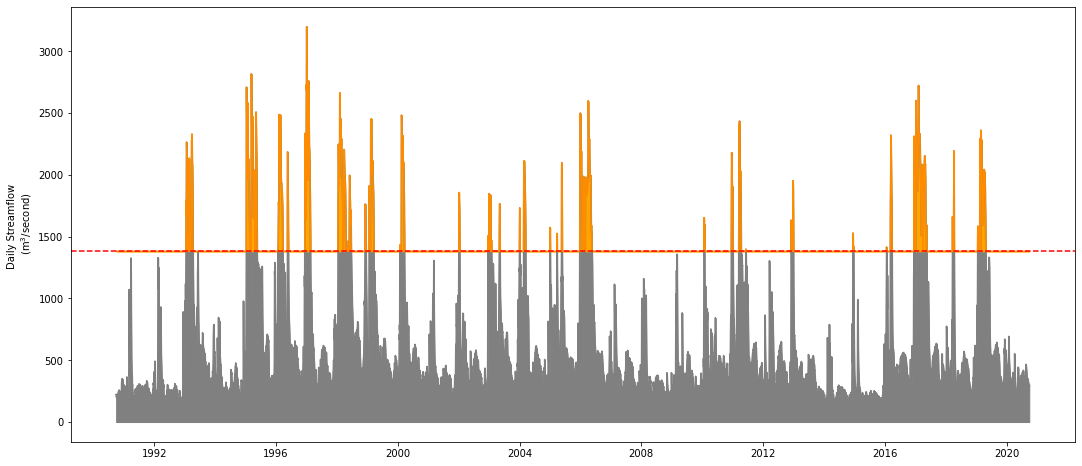

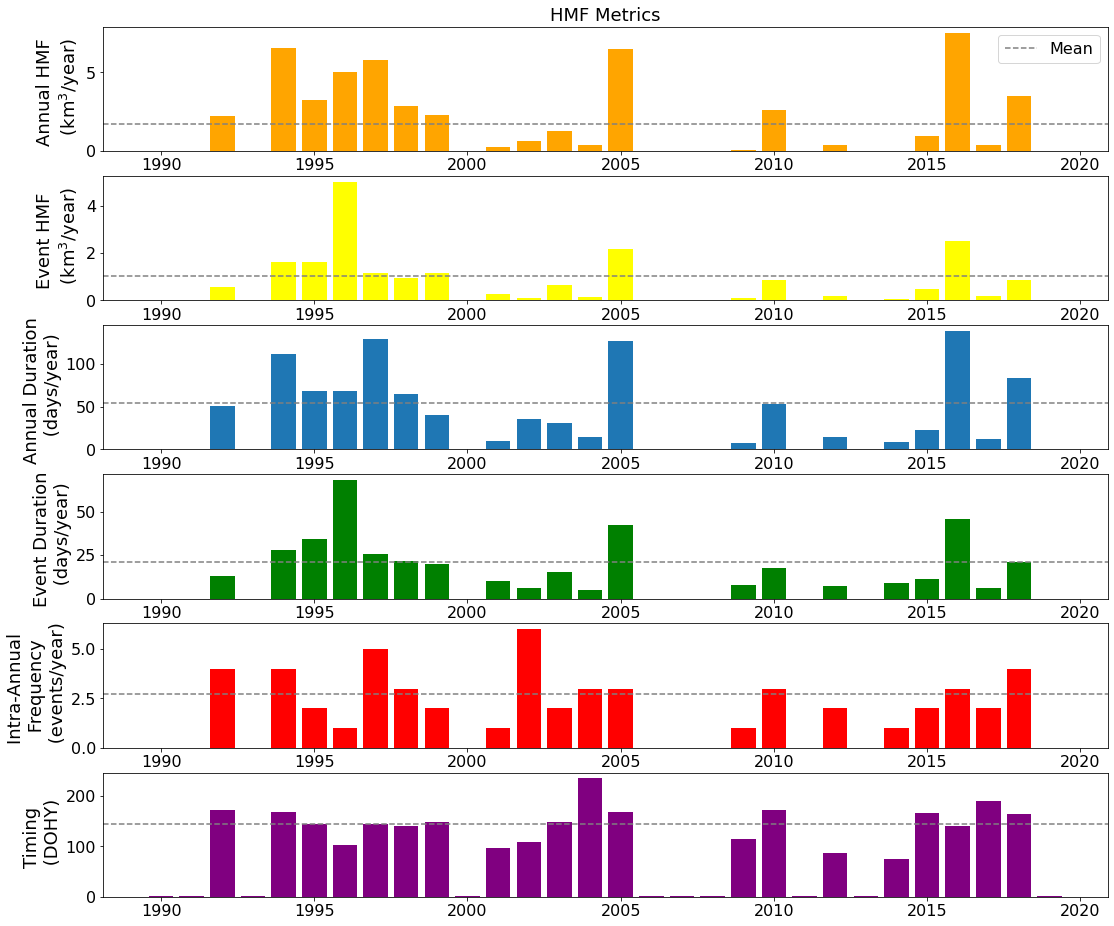

In [170]:
df_plot = df.reset_index()

threshold_cms = threshold * CFS_TO_CMS
df_plot['00060_Mean_cms'] = df_plot["00060_Mean"] * CFS_TO_CMS

df_plot["diff_cms"] = df_plot["00060_Mean_cms"] - threshold_cms
df_plot["hmf_cms"] = df_plot["diff_cms"].apply(lambda x: max(0, x))

start = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * data_range)
df_plot = df_plot[df_plot['datetime'].dt.date >= start]

fig, ax = plt.subplots(figsize=(18,8), nrows=1, ncols=1)

ax.plot(df_plot["datetime"], df_plot["00060_Mean_cms"], label="Streamflow", color="gray")
ax.plot(df_plot["datetime"], threshold_cms+df_plot["hmf_cms"], label="HMF", color="darkorange")
ax.axhline(y=threshold_cms, color='r', linestyle='--', label='Threshold')
ax.fill_between(df_plot["datetime"], df_plot["00060_Mean_cms"], color="gray")
ax.fill_between(df_plot["datetime"], y1=threshold_cms, y2=threshold_cms+df_plot["hmf_cms"], color="orange")
ax.set_ylabel('Daily Streamflow \n ($\mathregular{m^3}$/second)')

plt.show()

fig, ax = plt.subplots(figsize=(18,16), nrows=6, ncols=1)

ax[0].bar(df_results['Year'], annual_sum, color='orange')
ax[0].set_ylabel('Annual HMF \n ($\mathregular{km^3}$/year)', fontsize=18)
ax[0].axhline(y=annual_hmf, color='grey', linestyle='--', label='Mean')
ax[0].tick_params(axis='x', labelsize=16)
ax[0].tick_params(axis='y', labelsize=16) 
ax[0].legend(fontsize=16)

ax[1].bar(df_results['Year'], df_results['event_hmf'], color='yellow')
ax[1].set_ylabel('Event HMF \n ($\mathregular{km^3}$/year)', fontsize=18)
ax[1].axhline(y=event_hmf, color='grey', linestyle='--')
ax[1].tick_params(axis='x', labelsize=16)
ax[1].tick_params(axis='y', labelsize=16)

ax[2].bar(df_results['Year'], df_results['total_days'])
ax[2].axhline(y=annual_duration, color='grey', linestyle='--')
ax[2].set_ylabel('Annual Duration \n (days/year)', fontsize=18)
ax[2].tick_params(axis='x', labelsize=16)
ax[2].tick_params(axis='y', labelsize=16)

ax[3].bar(df_results['Year'], df_results['duration'], color='green')
ax[3].set_ylabel('Event Duration \n (days/year)', fontsize=18)
ax[3].axhline(y=event_duration, color='grey', linestyle='--')
ax[3].tick_params(axis='x', labelsize=16)
ax[3].tick_params(axis='y', labelsize=16)

ax[4].bar(df_results['Year'], df_results['total_events'], color='red')
ax[4].set_ylabel('Intra-Annual \n Frequency \n (events/year)', fontsize=18)
ax[4].axhline(y=intra_annual, color='grey', linestyle='--')
ax[4].tick_params(axis='x', labelsize=16)
ax[4].tick_params(axis='y', labelsize=16)

ax[5].bar(df_results['Year'], com_series_cont, color='purple')
ax[5].set_ylabel('Timing \n (DOHY)', fontsize=18)
ax[5].axhline(y=com_series.mean(), color='grey', linestyle='--')
ax[5].tick_params(axis='x', labelsize=16)
ax[5].tick_params(axis='y', labelsize=16)

# Plot month names instead of numerical dates
#plt.gca().xaxis.set_major_locator(MonthLocator())
#plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))  # %b for month abbreviation
#ax.xticks(rotation=45, fontsize=18)
#ax.xlabel("Date", fontsize=20)

ax[0].set_title('HMF Metrics', fontsize=18)

plt.savefig(f'Saved_Visuals/hyd201b_presentation/30_year_rec_metrics_{site_no}.png', bbox_inches='tight')

plt.show()

### Plot metrics for individual years and QA/QC

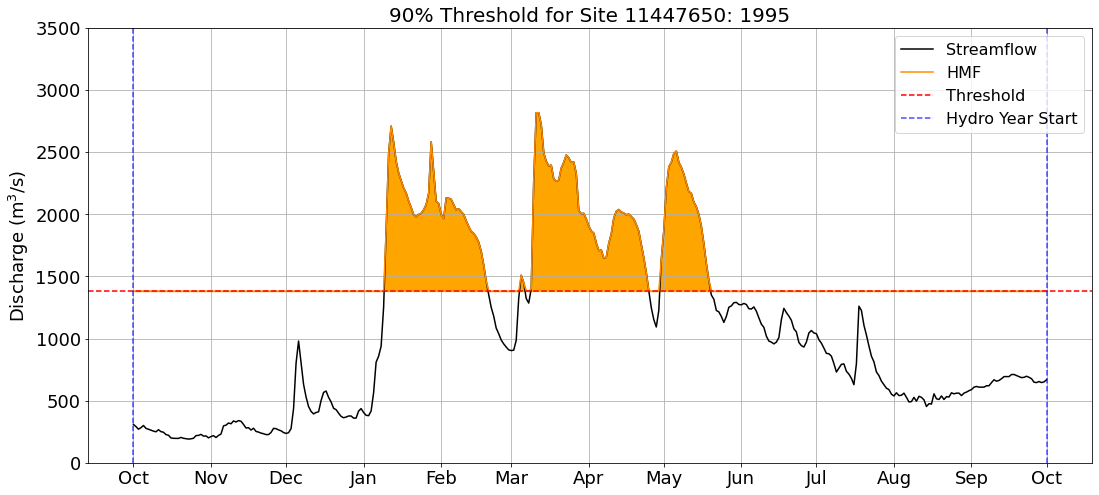

In [210]:
df_plot = df.reset_index()

threshold_cms = threshold * CFS_TO_CMS
df_plot['00060_Mean_cms'] = df_plot["00060_Mean"] * CFS_TO_CMS

df_plot["diff_cms"] = df_plot["00060_Mean_cms"] - threshold_cms
df_plot["hmf_cms"] = df_plot["diff_cms"].apply(lambda x: max(0, x))

start = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * data_range)
df_plot = df_plot[df_plot['datetime'].dt.date >= start]

def plot_annual_hmf_metric(df, year, save=False):
    # Select certain dates to plot
    PLOT_START = str(year)+'-10-01'
    next_year = year+1
    PLOT_END = str(next_year)+'-10-01'
    df_plot = df.loc[(df['datetime'] >= PLOT_START) & (df['datetime'] <= PLOT_END)]

    plt.figure(figsize=(18, 8))

    plt.plot(df_plot["datetime"], df_plot["00060_Mean_cms"], label="Streamflow", color="black")
    plt.plot(df_plot["datetime"], threshold_cms+df_plot["hmf_cms"], label="HMF", color="darkorange")
    plt.axhline(y=threshold_cms, color='r', linestyle='--', label='Threshold')

    #plt.fill_between(df_plot["datetime"], df_plot["00060_Mean_cms"], color="gray")
    plt.fill_between(df_plot["datetime"], y1=threshold_cms, y2=threshold_cms+df_plot["hmf_cms"], color="orange")

    # Plot vertical lines to separate water years
    first = True
    for year in range(df_plot["datetime"].dt.year.min(), df_plot["datetime"].dt.year.max() + 1):
        oct1 = pd.to_datetime(f'{year}-10-01')
        if first:
            plt.axvline(oct1, color='blue', linestyle='--', alpha=0.7, label='Hydro Year Start')
            first = False
        else:
            plt.axvline(oct1, color='blue', linestyle='--', alpha=0.7) 

    # Plot month names instead of numerical dates
    plt.gca().xaxis.set_major_locator(MonthLocator())
    plt.gca().xaxis.set_major_formatter(DateFormatter('%b'))  # %b for month abbreviation
    plt.xticks(rotation=0, fontsize=18)
    #plt.xlabel("Date", fontsize=18)

    plt.yticks(fontsize=18)
    plt.ylabel('Discharge ($\mathregular{m^3}$/s)', fontsize=18)
    plt.ylim(0, 3500)

    plt.title(f"{quantile*100:.0f}% Threshold for Site {site_no}: {year}", fontsize=20)
    plt.grid(True)
    plt.legend(loc=1, fontsize=16)
    
    
    # print(f'Year: {df_results["Year"][i]}')
    # print(f'Annual HMF: {annual_sum[i]}')
    # print(f'Event HMF: {df_results["event_hmf"][i]}')
    # print(f'Annual Duration: {df_results["total_days"][i]}')
    # print(f'Event Duration: {df_results["duration"][i]}')
    # print(f'Intra-Annual Frequency: {df_results["total_events"][i]}')
    # #print(f'Timing: {com_series.tolist()[i]}')
    # print(df_plot['hmf_cms'].tolist())
    
    if save == True:
        plt.savefig(f'Saved_Visuals/timeseries_one_year_metrics_{site_no}.png', bbox_inches='tight')
    plt.show()
    
#for i, year in enumerate(df_plot['datetime'].dt.year.unique()):
#    plot_annual_hmf_metric(df_plot, year, False)
    
plot_annual_hmf_metric(df_plot, 1994, True)

In [73]:
df_plot = df.reset_index()

threshold_cms = threshold * CFS_TO_CMS
df_plot['00060_Mean_cms'] = df_plot["00060_Mean"] * CFS_TO_CMS

df_plot["diff_cms"] = df_plot["00060_Mean_cms"] - threshold_cms
df_plot["hmf_cms"] = df_plot["diff_cms"].apply(lambda x: max(0, x))

start = pd.to_datetime(fn.DEFAULT_END).date() - timedelta(days=365.25 * data_range)
df_plot = df_plot[df_plot['datetime'].dt.date >= start]
df_plot

datetime  00060_Mean 00060_Mean_cd   site_no  \
15340 1990-10-01 00:00:00+00:00      7880.0             A  11447650   
15341 1990-10-02 00:00:00+00:00      7940.0             A  11447650   
15342 1990-10-03 00:00:00+00:00      7640.0             A  11447650   
15343 1990-10-04 00:00:00+00:00      7070.0             A  11447650   
15344 1990-10-05 00:00:00+00:00      7080.0             A  11447650   
...                         ...         ...           ...       ...   
26294 2020-09-26 00:00:00+00:00     10700.0           NaN  11447650   
26295 2020-09-27 00:00:00+00:00     10700.0           NaN  11447650   
26296 2020-09-28 00:00:00+00:00     10700.0           NaN  11447650   
26297 2020-09-29 00:00:00+00:00     10500.0           NaN  11447650   
26298 2020-09-30 00:00:00+00:00     10600.0           NaN  11447650   

       72137_Mean 72137_Mean_cd  00060_Mean_cms     diff_cms  hmf_cms  
15340         NaN           NaN      223.136751 -1158.725363      0.0  
15341         NaN           NaN      224.835762 -1157.026352      0.0  
15342         NaN           NaN      216.340708 -1165.521406      0.0  
15343         NaN           NaN      200.200105 -1181.662008      0.0  
15344         NaN           NaN      200.483274 -1181.378840      0.0  
...           ...           ...             ...          ...      ...  
26294     10700.0             A      302.990259 -1078.871855      0.0  
26295     10700.0             A      302.990259 -1078.871855      0.0  
26296     10700.0             A      302.990259 -1078.871855      0.0  
26297     10500.0             A      297.326889 -1084.535224      0.0  
26298     10600.0             A      300.158574 -1081.703540      0.0  

[10959 rows x 9 columns]

## SCRIPT: HUC2/4/Aquifer Sorting Validation
The code below is used to check that the HUC2/4/Aquifer boundaries assigned to each water gauge via the script in aquifer_analysis.ipynb are correct

In [ ]:
# Only need to run once, takes ~20s
huc2_shape = gpd.read_file('ShapeFiles/HUC2/_Master_HUC2/master_huc2.shp')
huc4_shape = gpd.read_file('ShapeFiles/HUC4/_Master_HUC4/master_huc4.shp')

In [8]:
# HUC's to plot
huc2_list = ['01']
huc4_list = ['1702', '1706', '0103', '0207']
dataset = 'Prelim_Data/_National_Metrics/National_Metrics_30_90.xlsx'
df = pd.read_excel(dataset, dtype={'site_no': str, 'huc2_code': str, 'huc4_code': str})

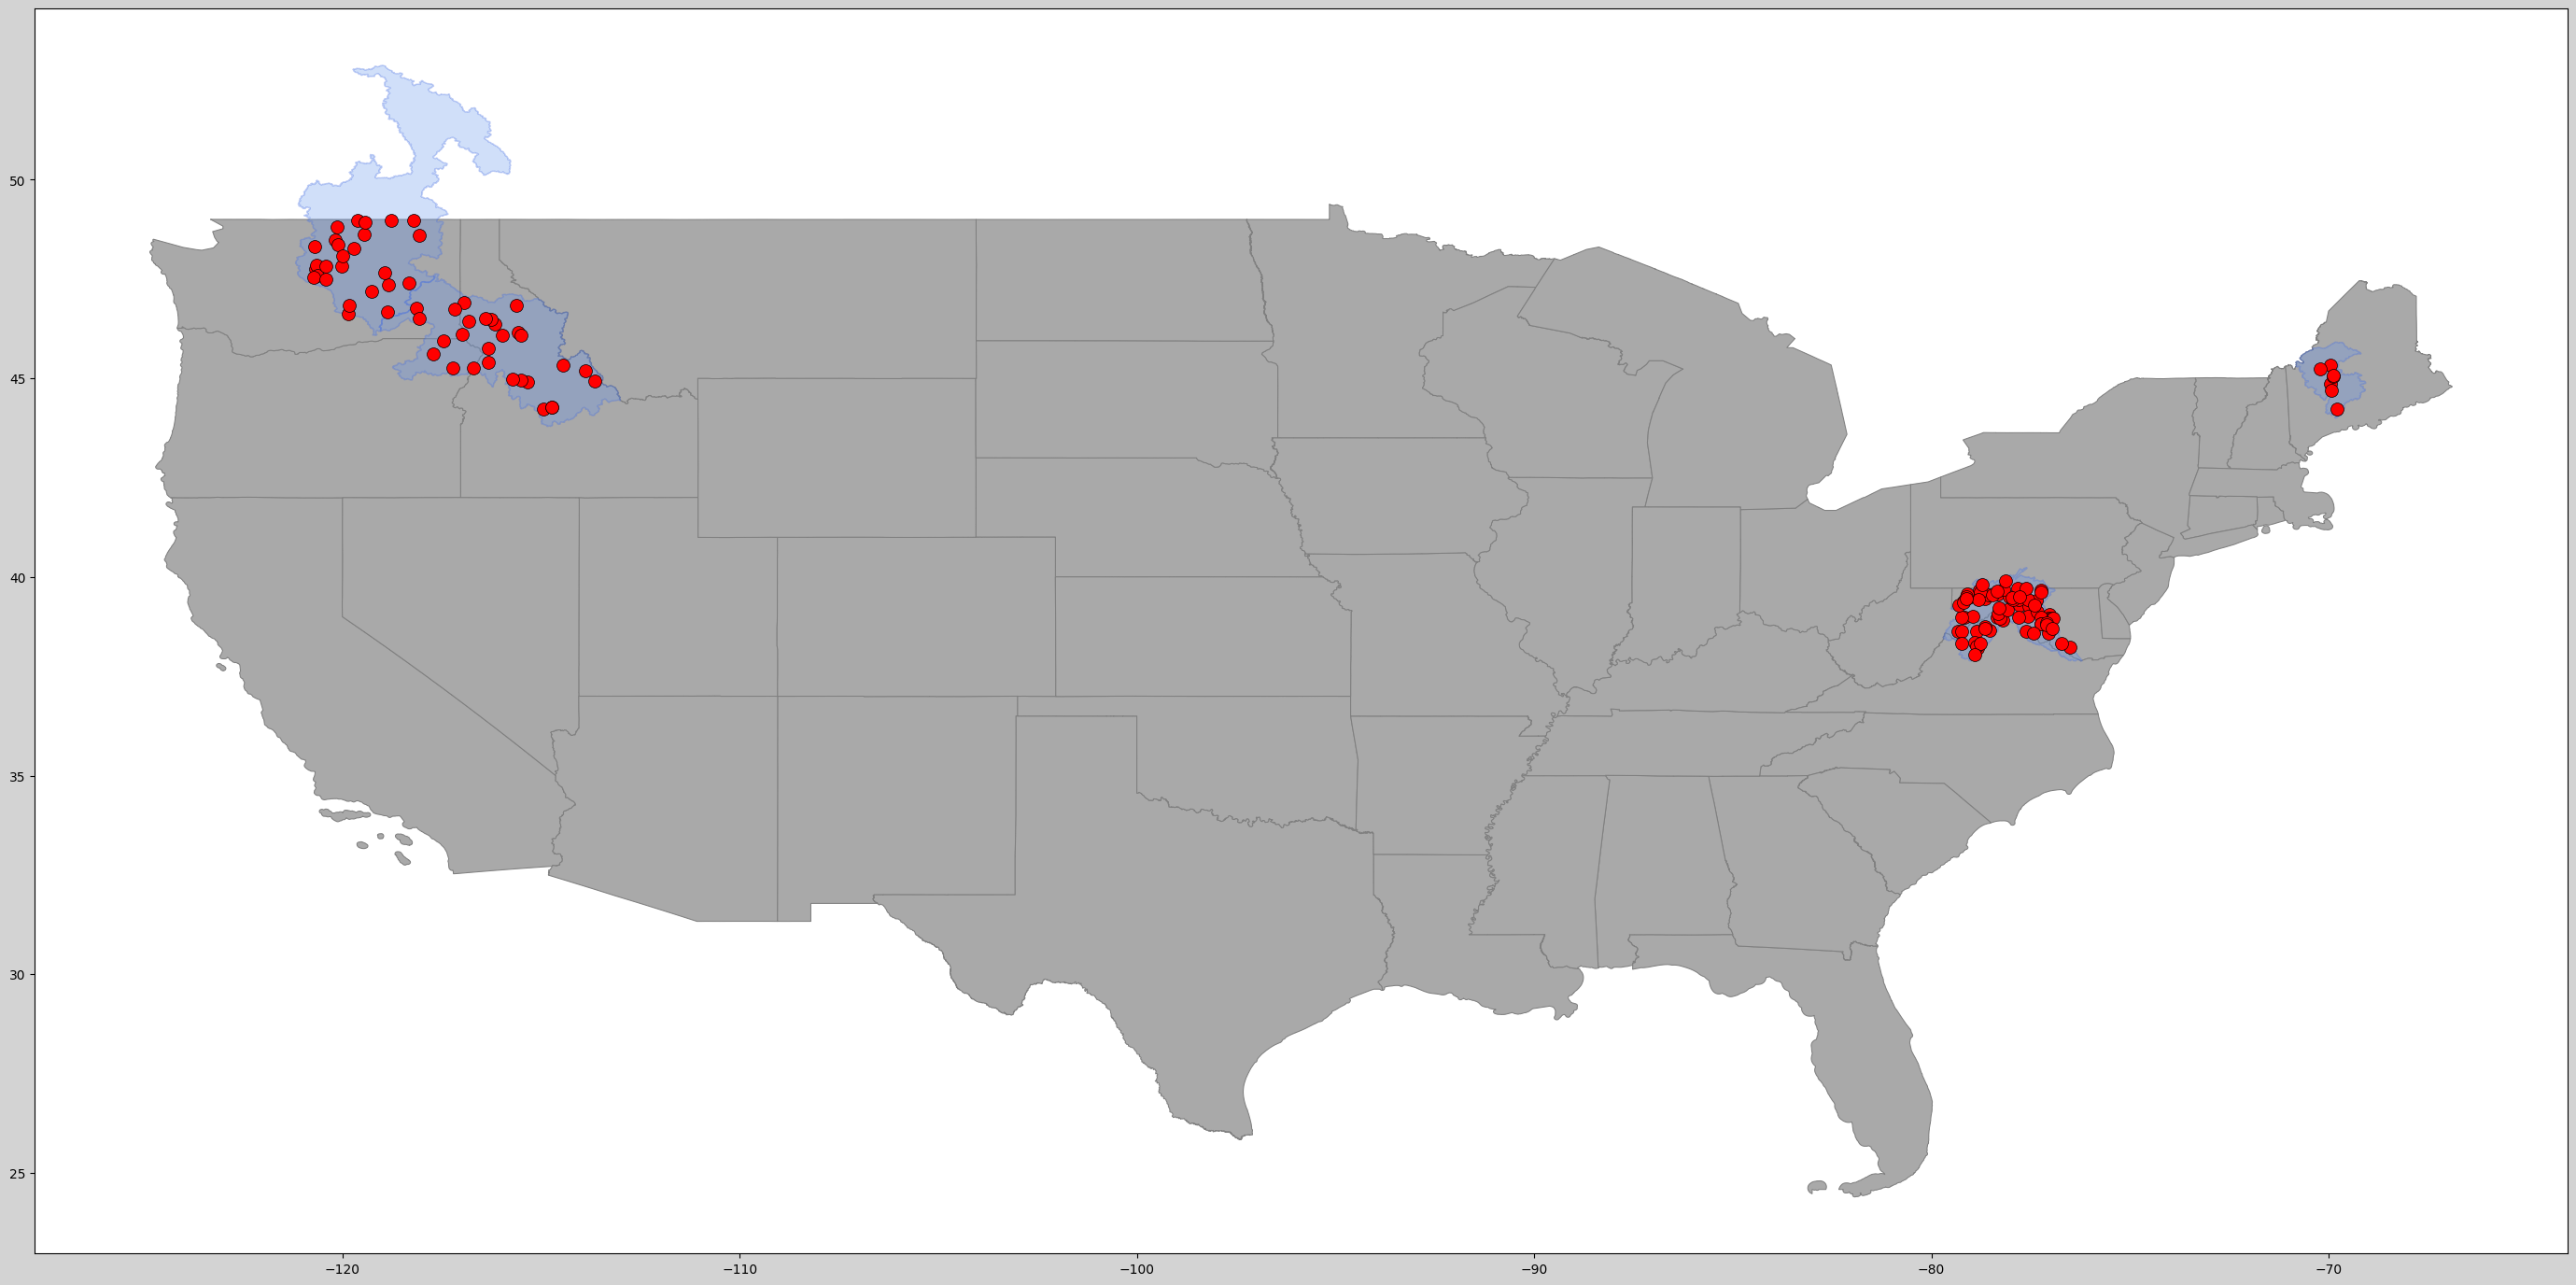

In [9]:
fig, ax = plt.subplots(figsize=(35, 35), facecolor='lightgray')
fn.plot_lower_48(ax)
fn.plot_huc4(ax, shapefile=huc4_shape, codes=huc4_list)
#fn.plot_huc2(ax, codes=huc2_list)

df = df[df['huc4_code'].isin(huc4_list)]
geo_df = fn.convert_geometry(df)

geo_df.plot(ax=ax, color='red', edgecolor='black', markersize=100, linewidth=0.5, alpha=1.0)
plt.show()

## SCRIPT: Master HUC2/HUC4/Aquifer Shapefile Validation
This code is for visually confirming that all HUC2s/HUC4s/Aquifers are included in their respective shapefiles

In [3]:
shapefile = gpd.read_file('ShapeFiles/HUC4/_Master_HUC4/master_huc4.shp')

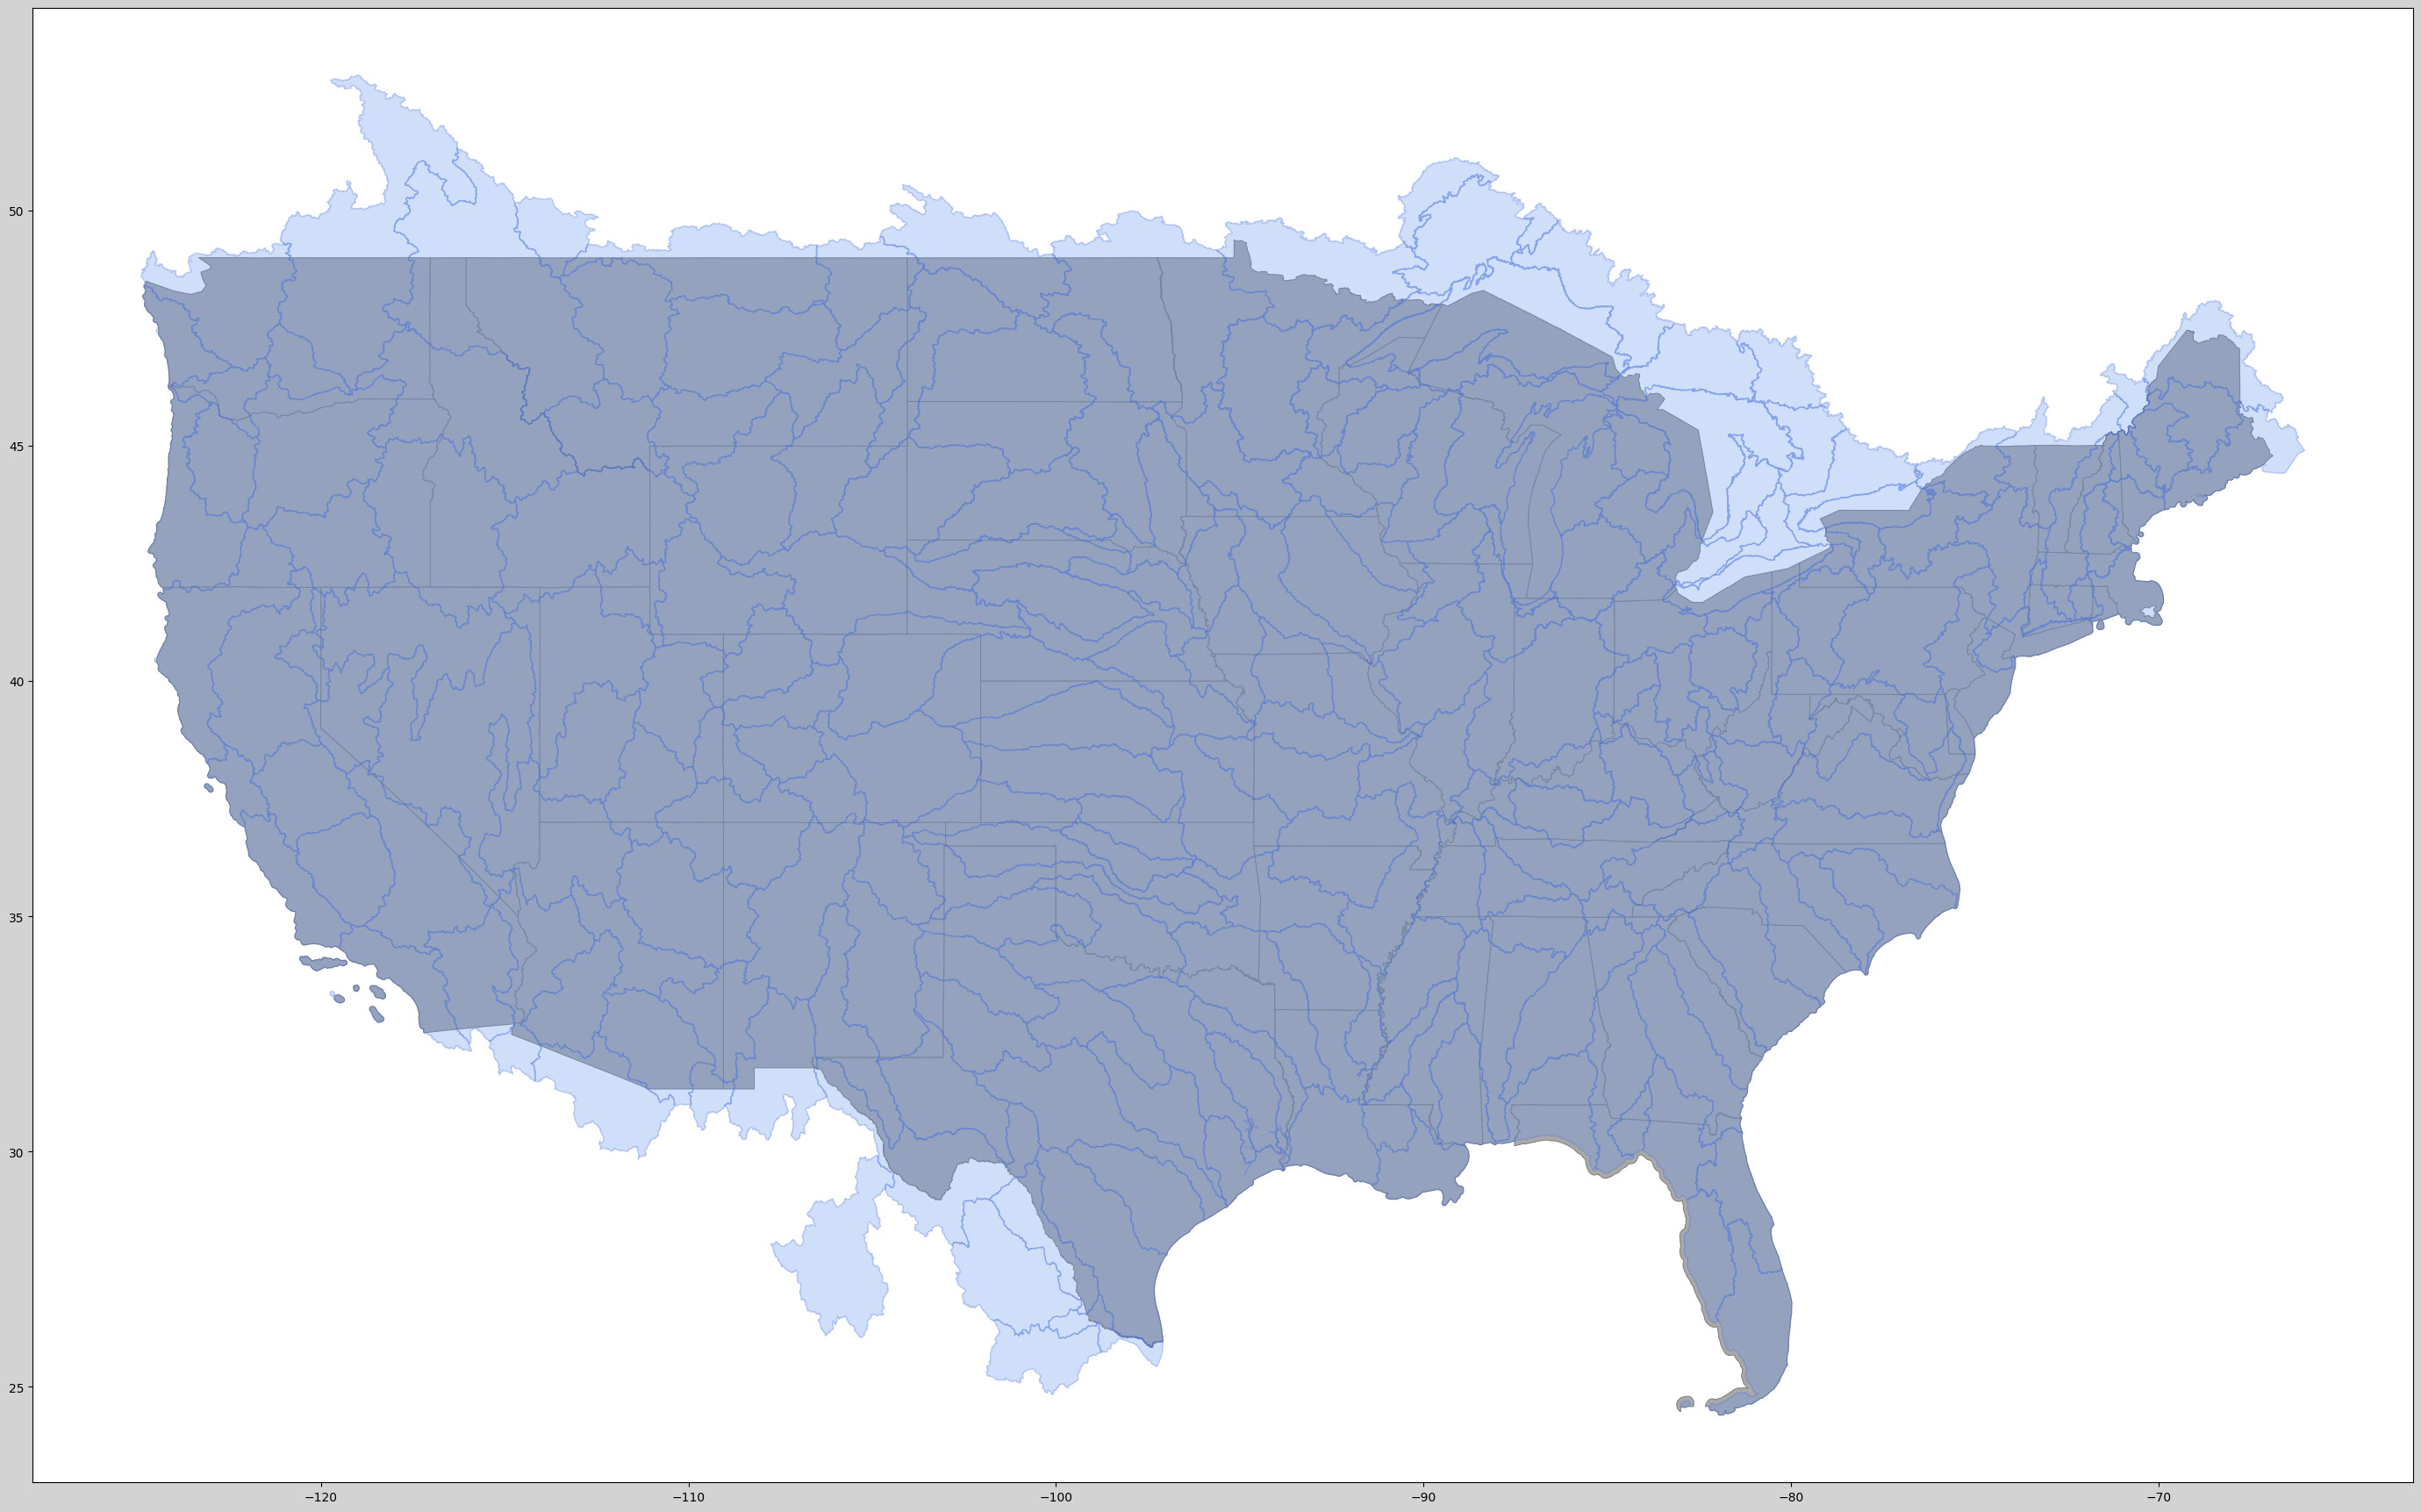

In [7]:
fig, ax = plt.subplots(figsize=(35, 35), facecolor='lightgray')
fn.plot_lower_48(ax)
fn.plot_huc4(ax, shapefile)
plt.show()

## Streamflow timeseries for gages in given aquifer

In [182]:
import pickle
with open("test", "rb") as fp:
    sites_cv = pickle.load(fp)

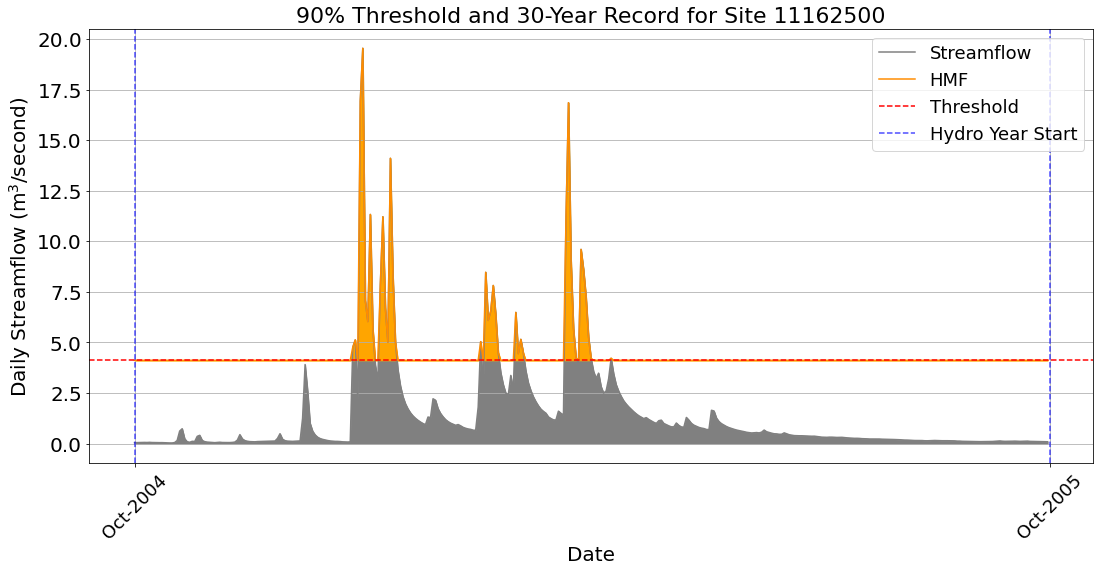

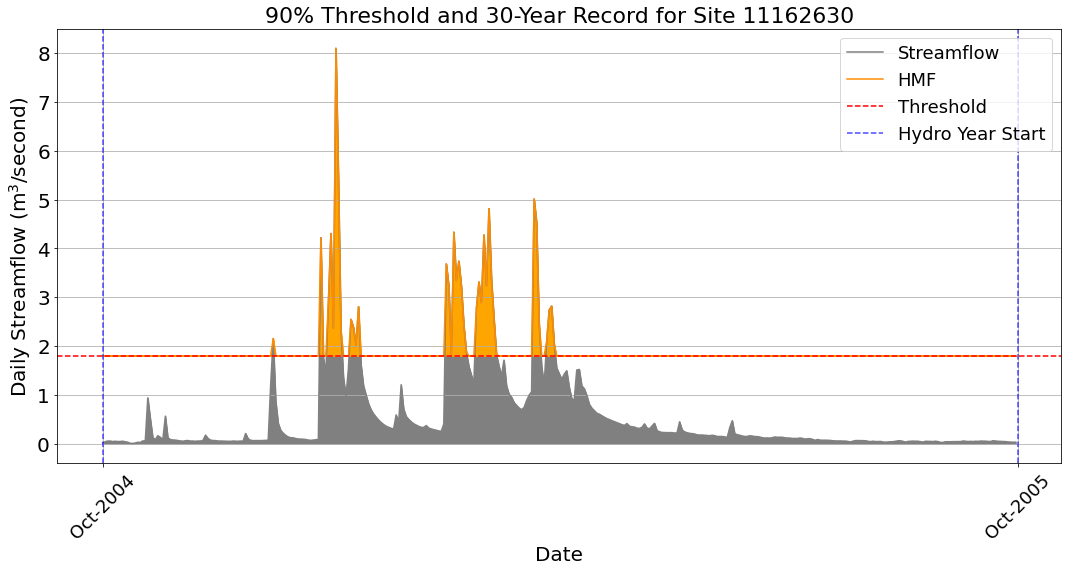

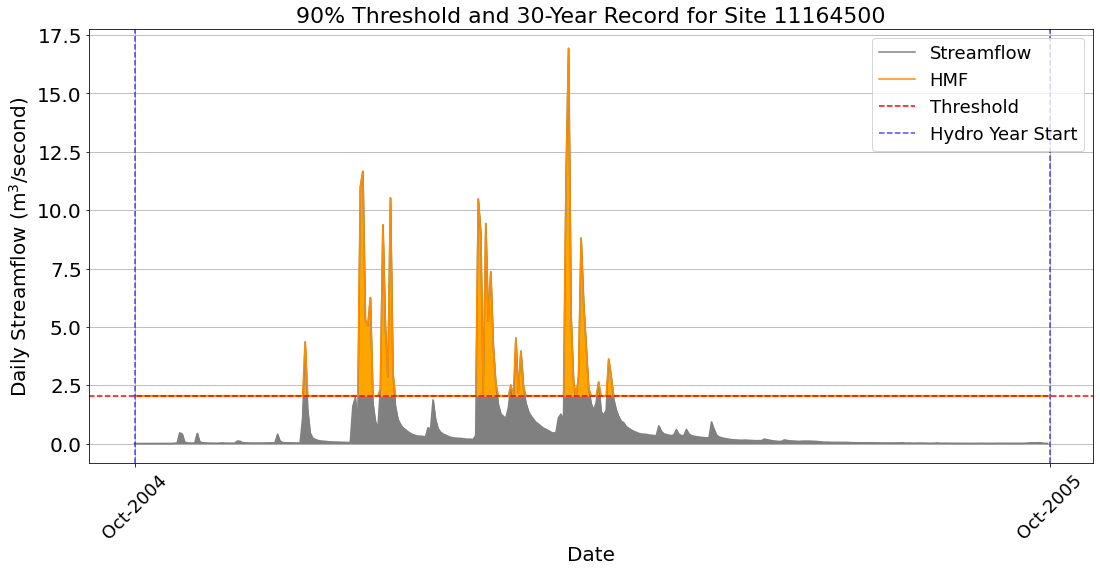

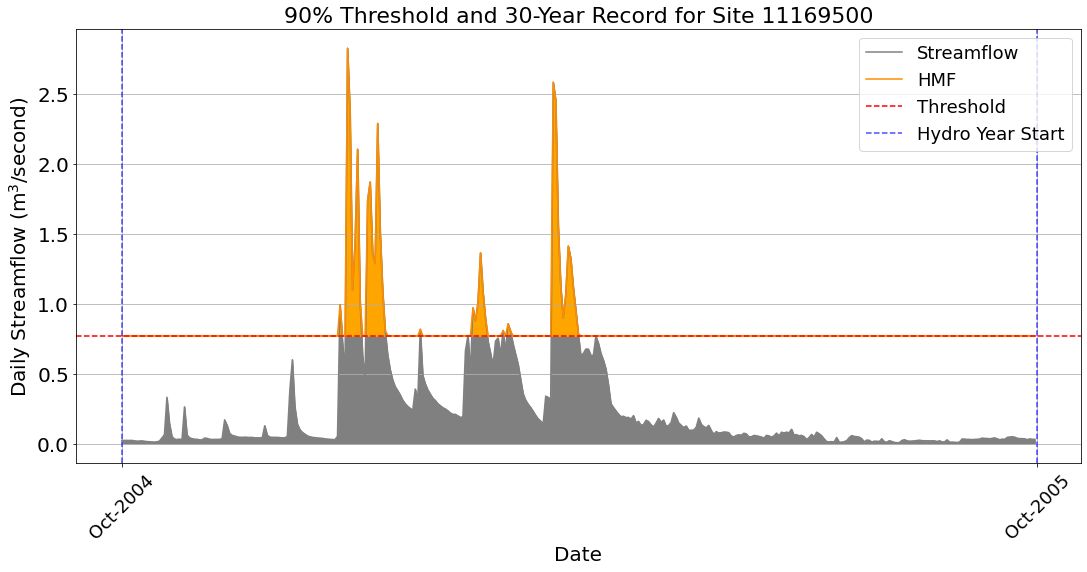

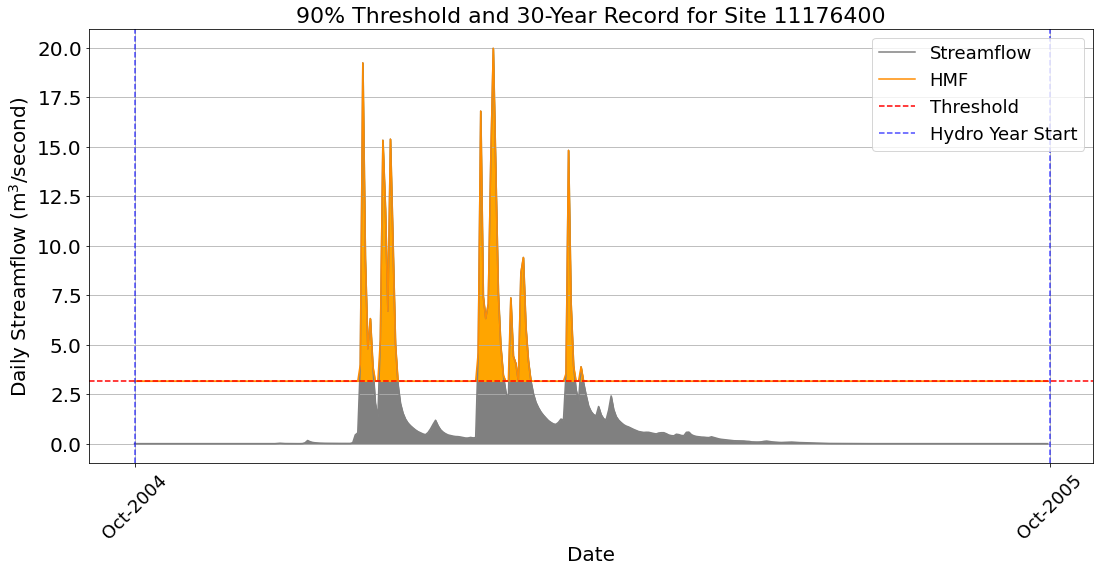

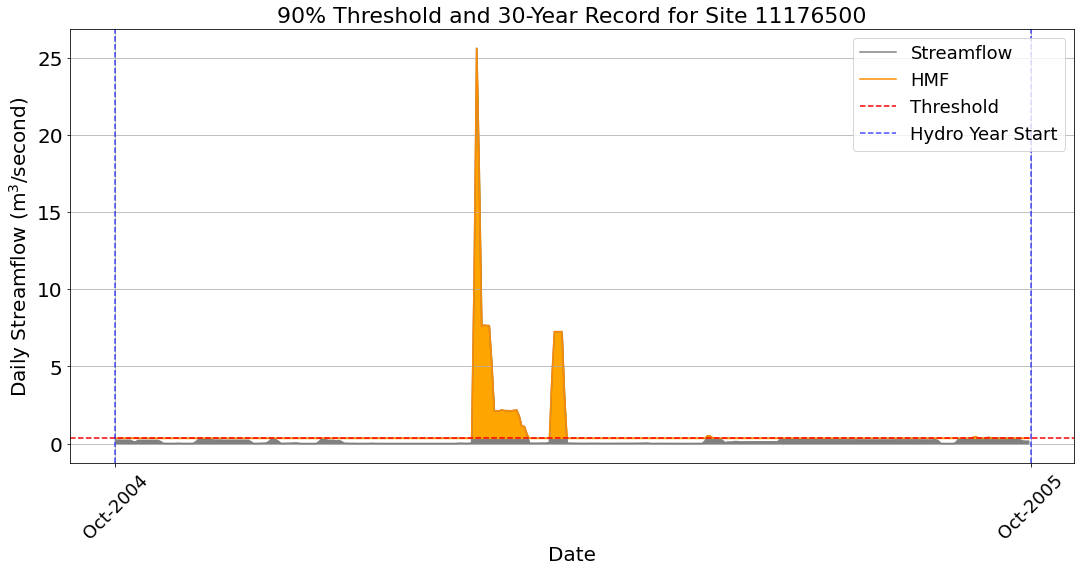

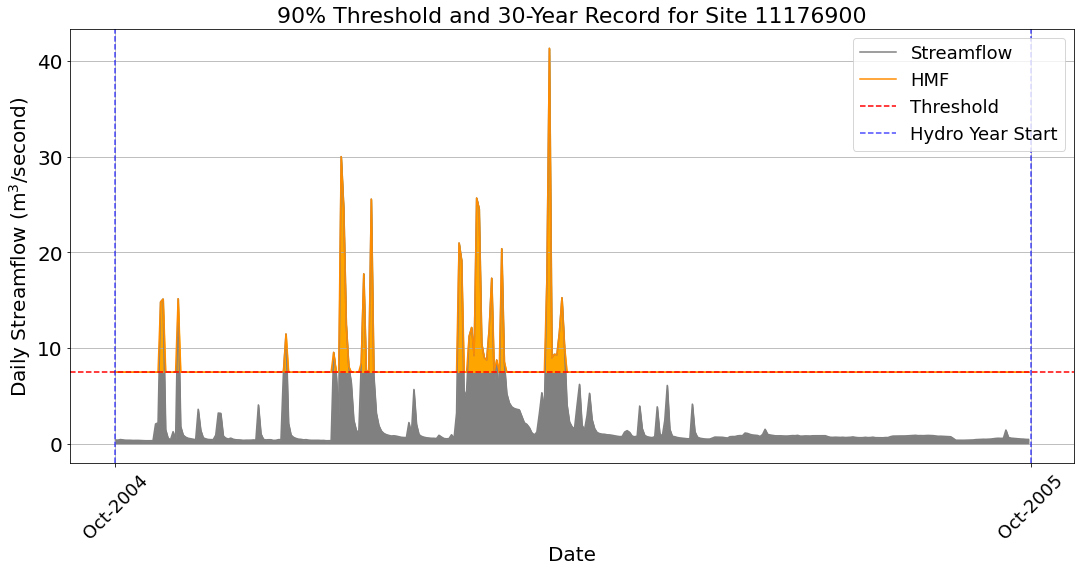

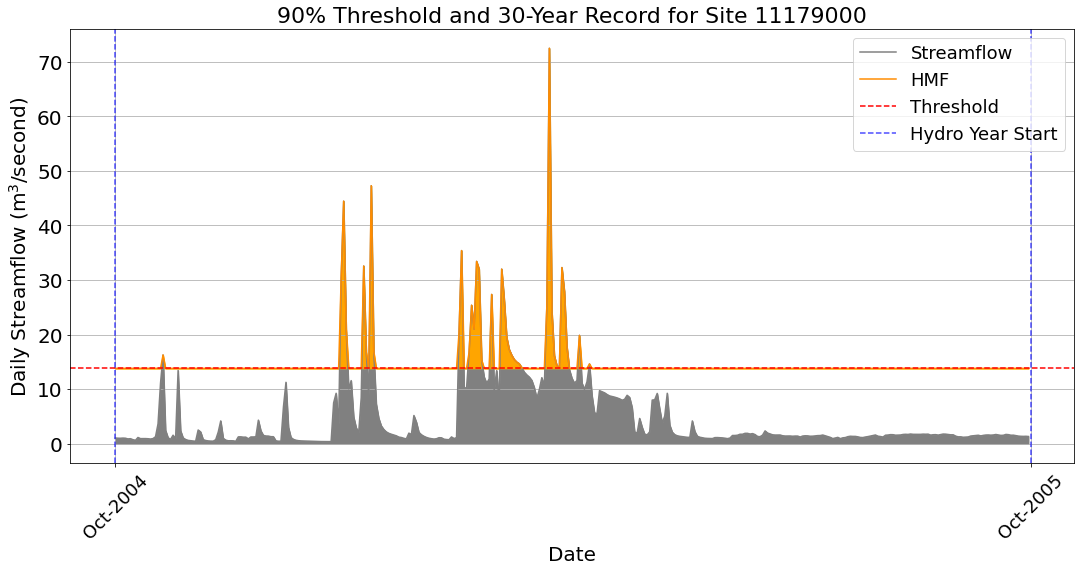

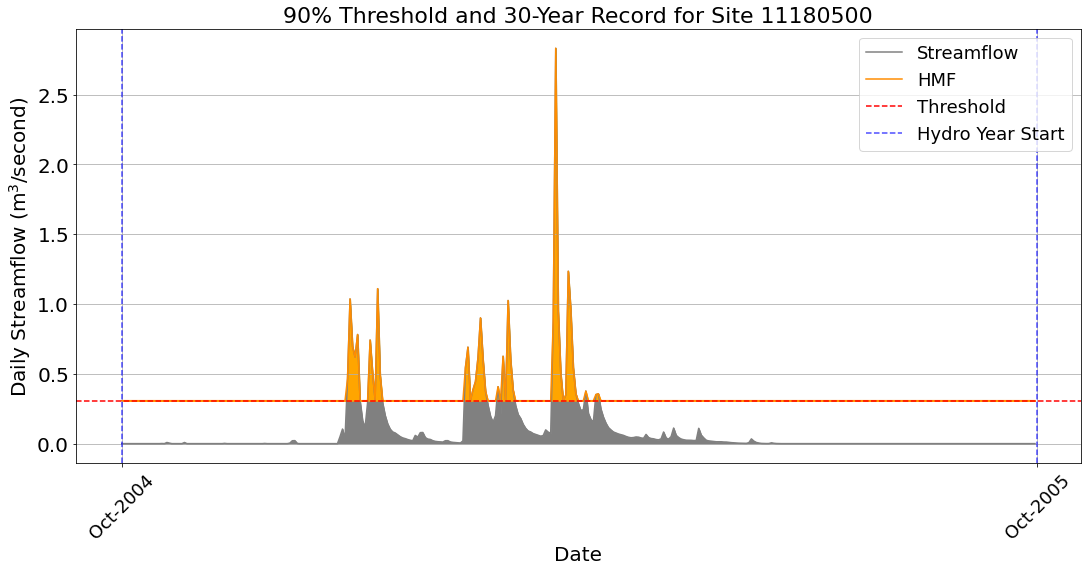

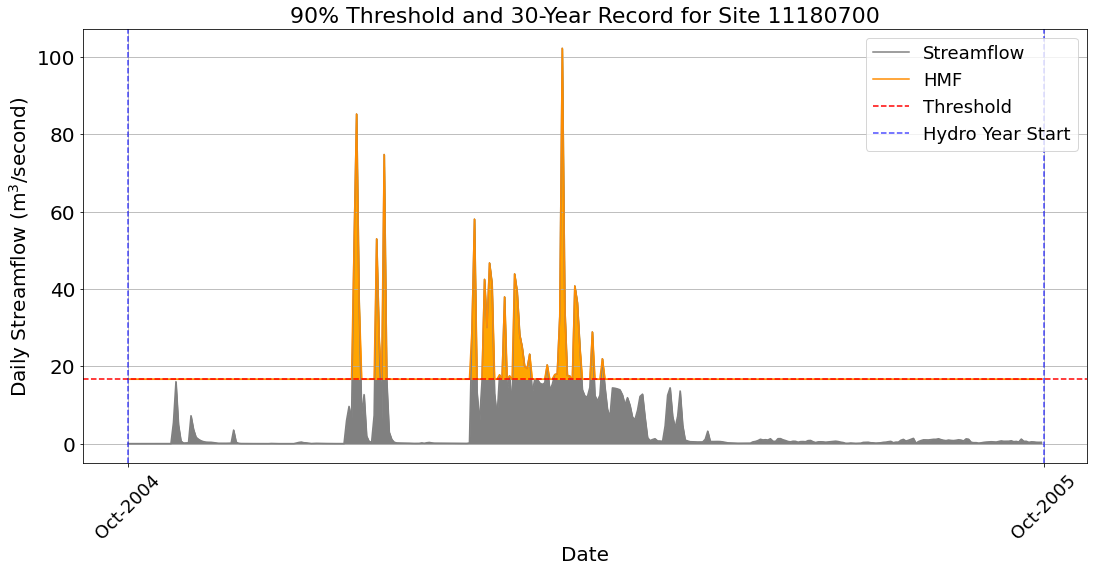

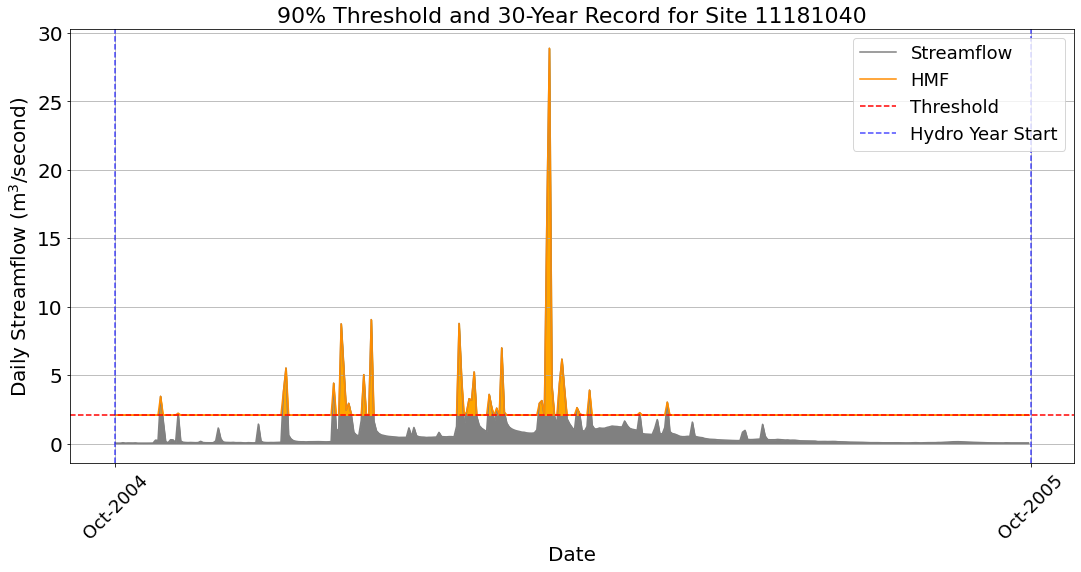

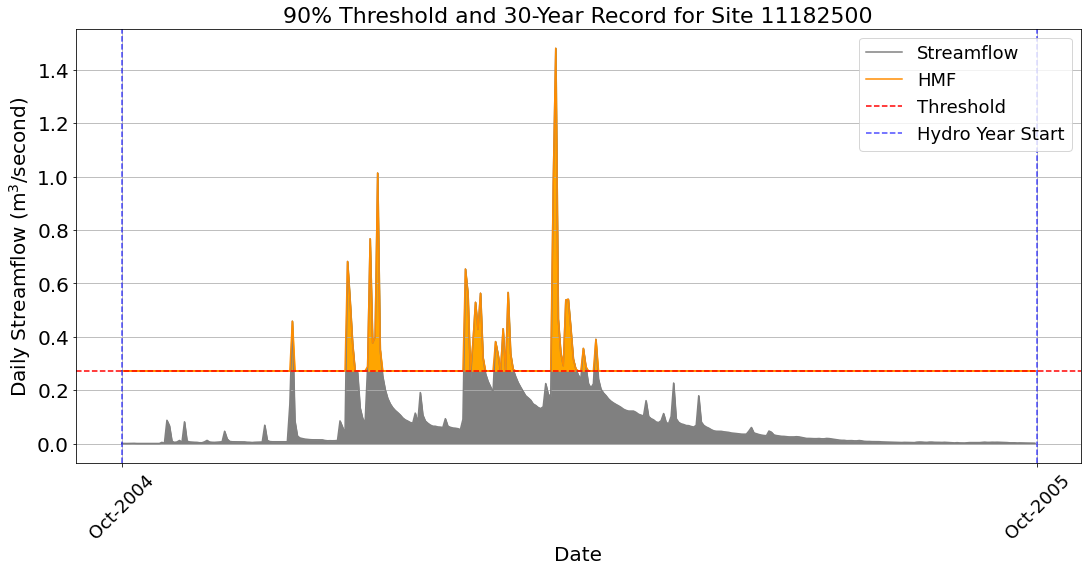

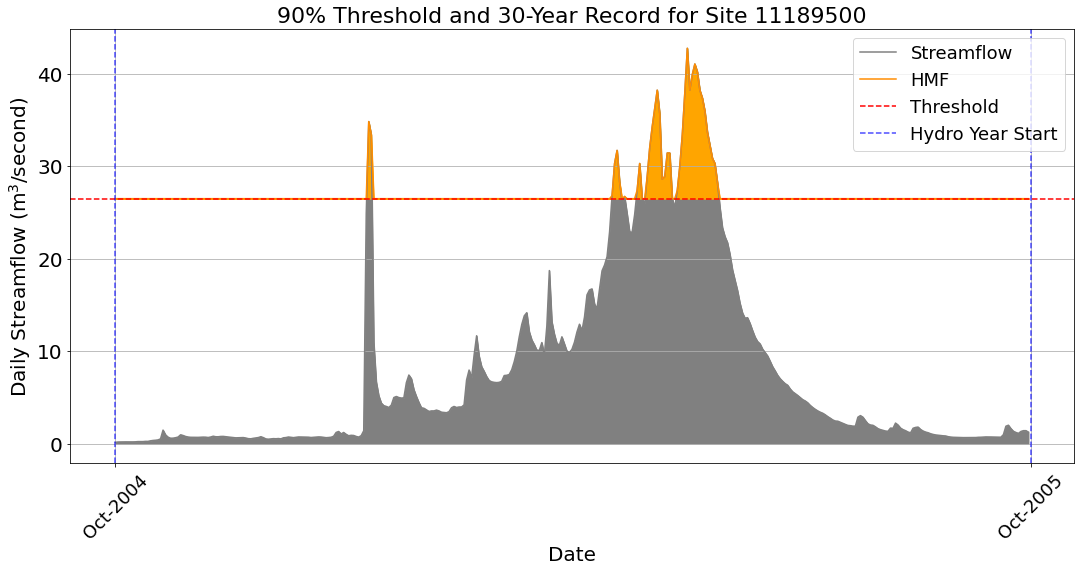

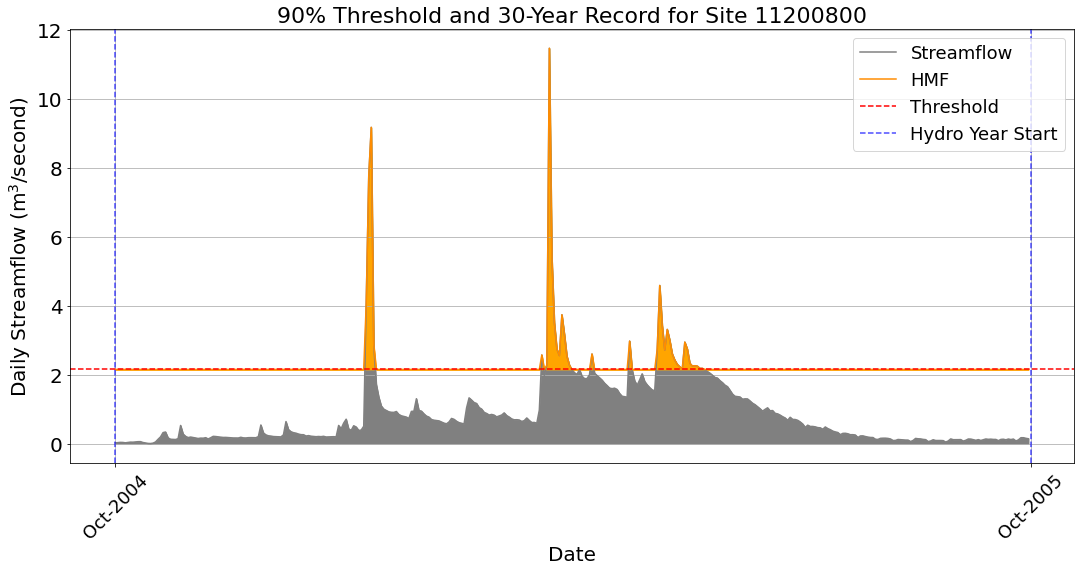

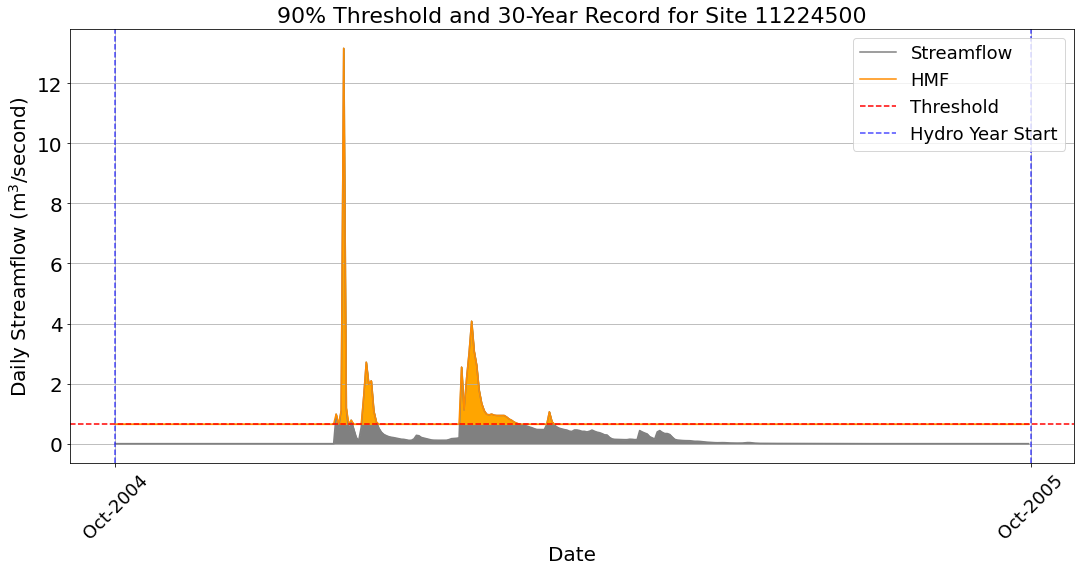

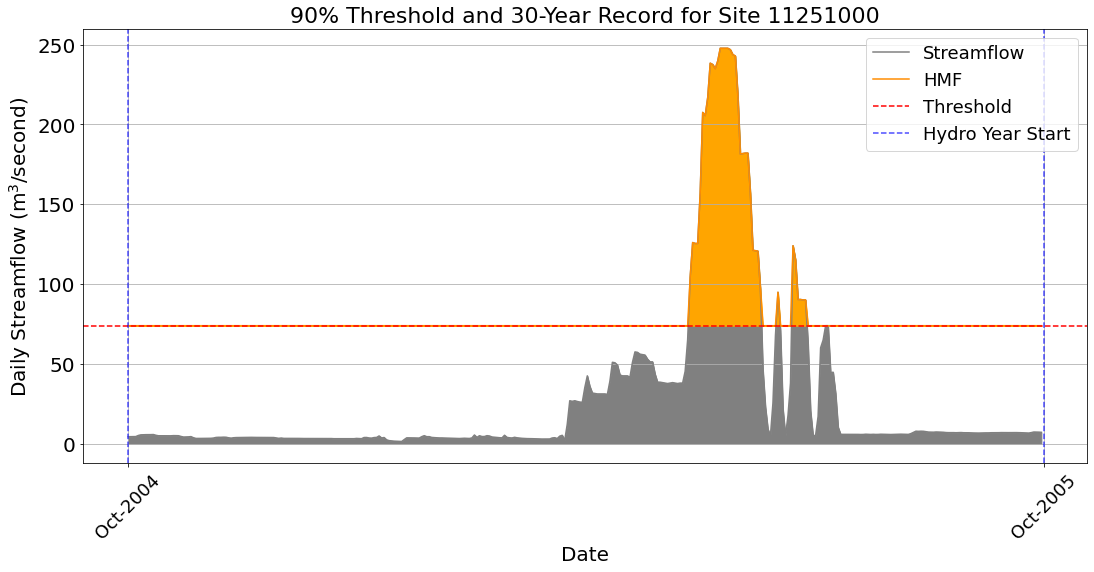

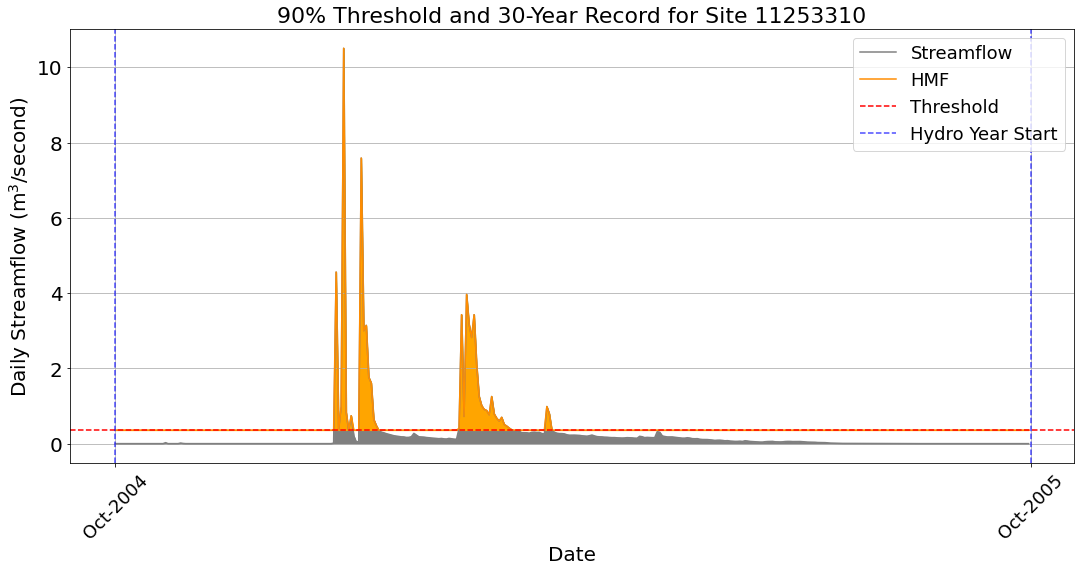

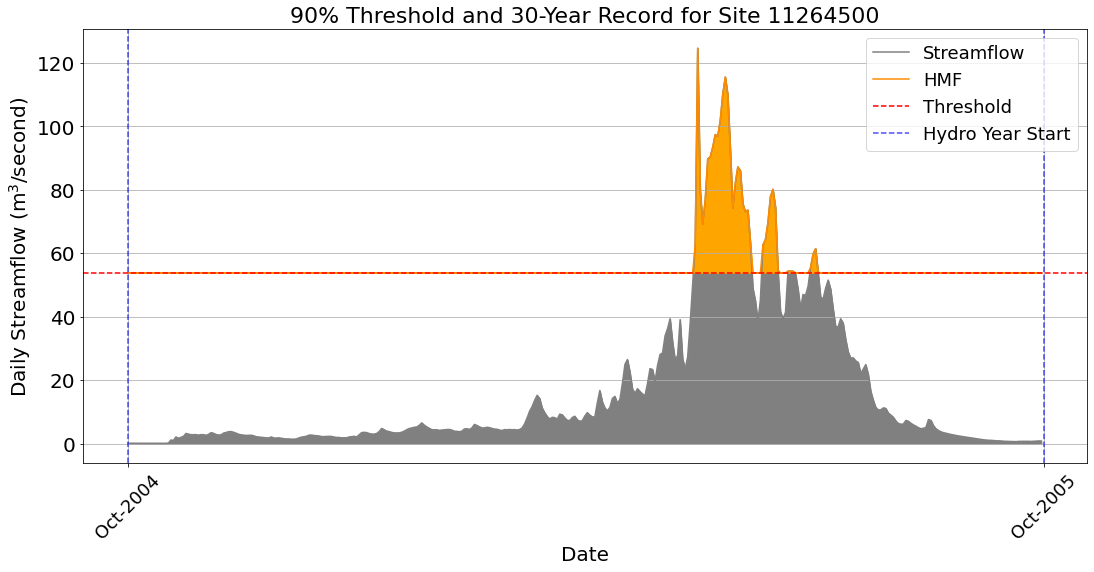

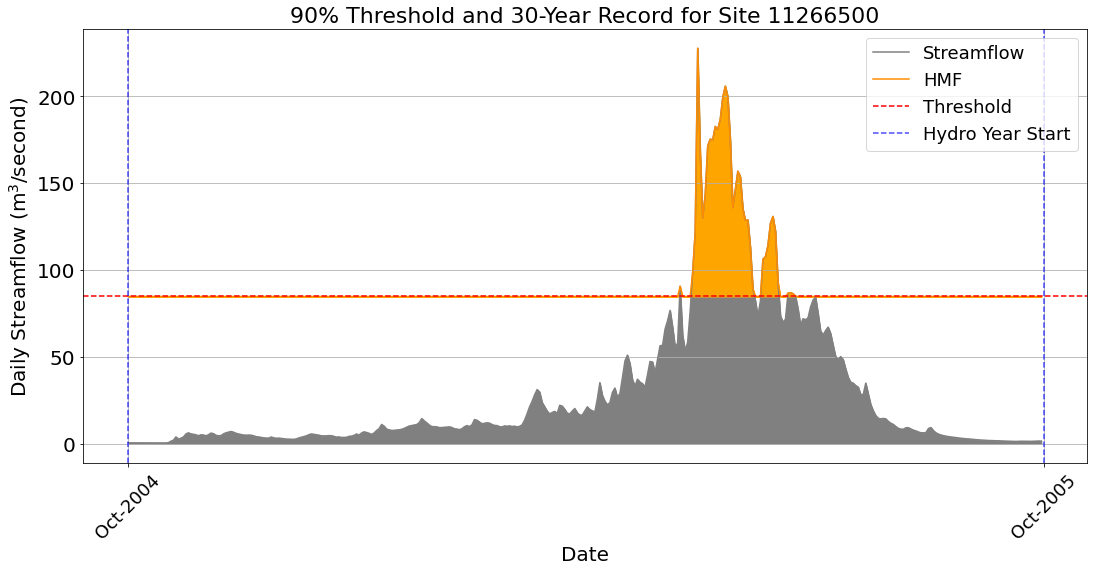

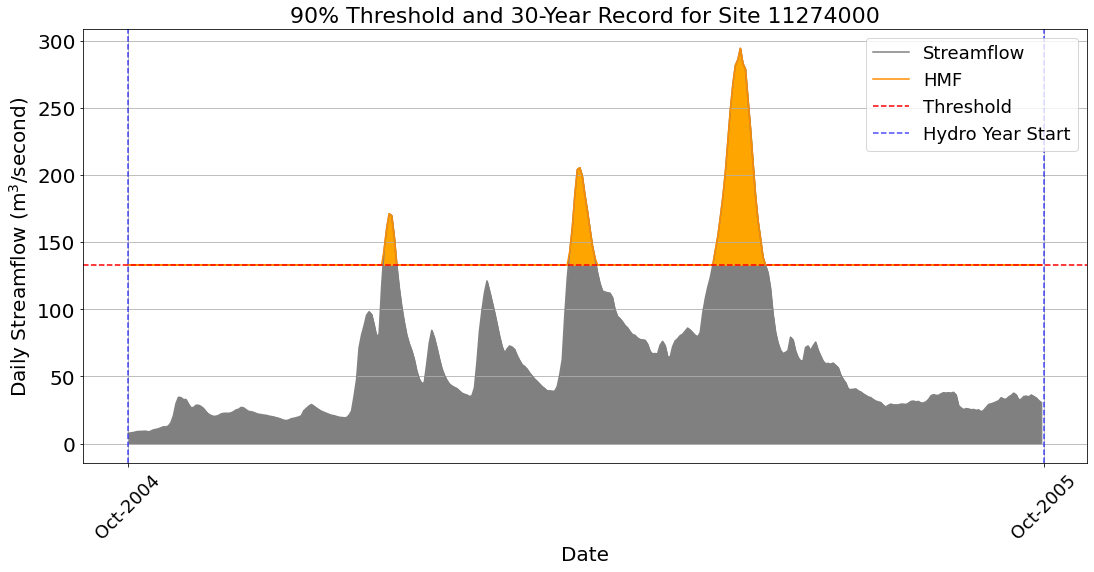

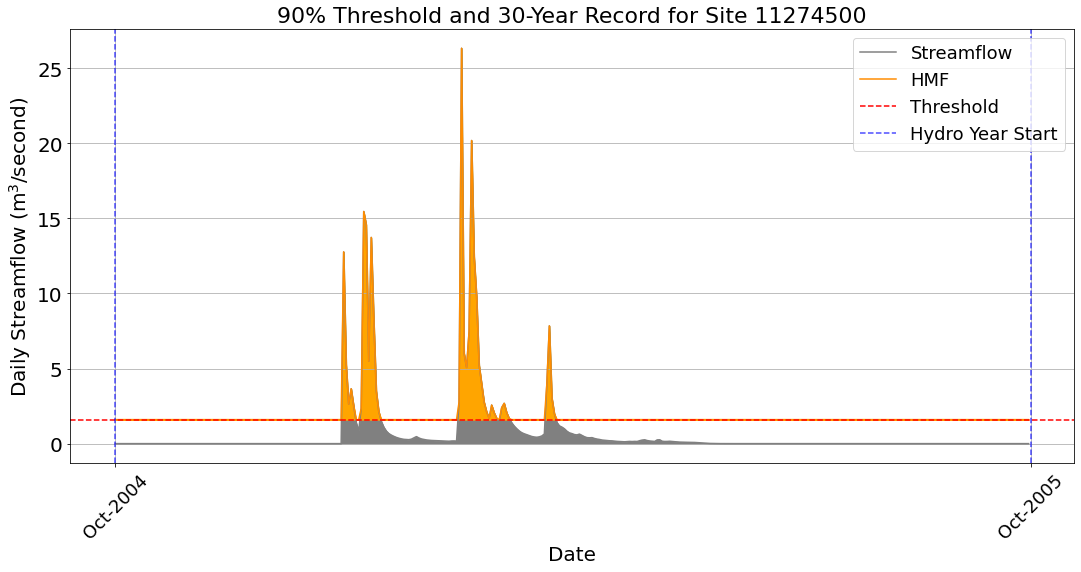

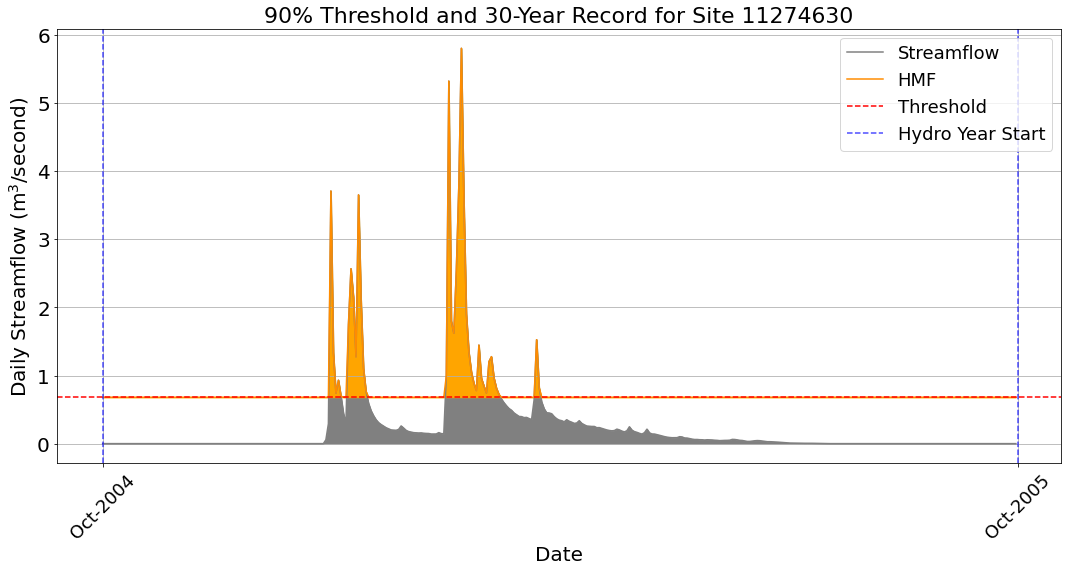

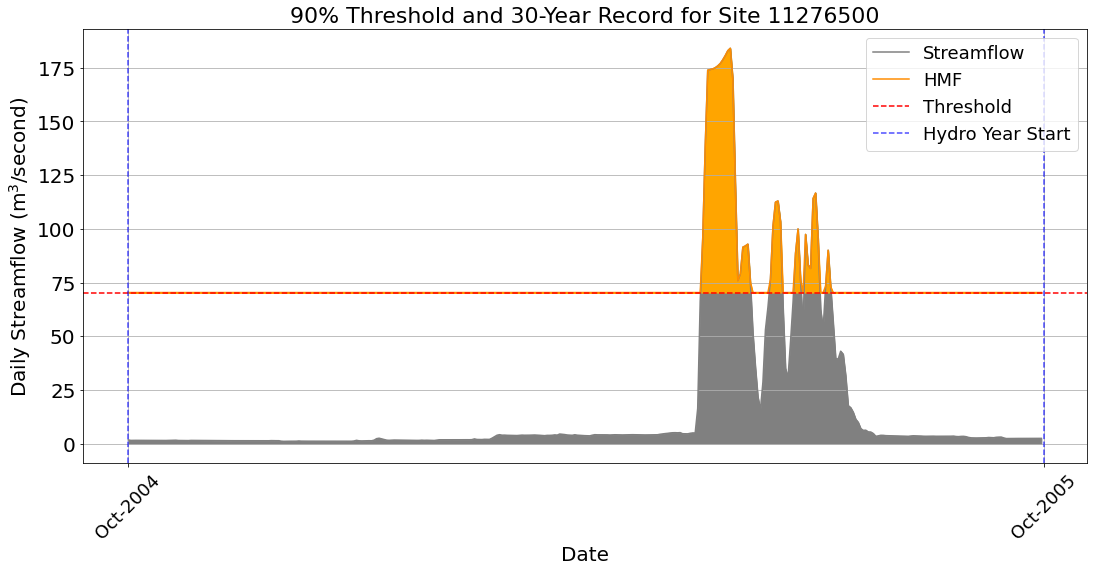

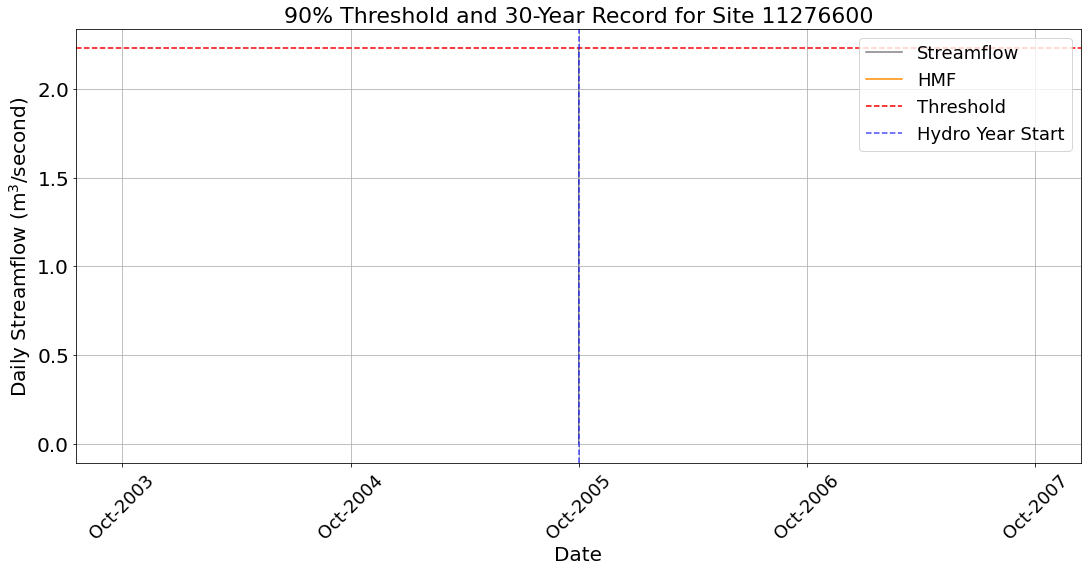

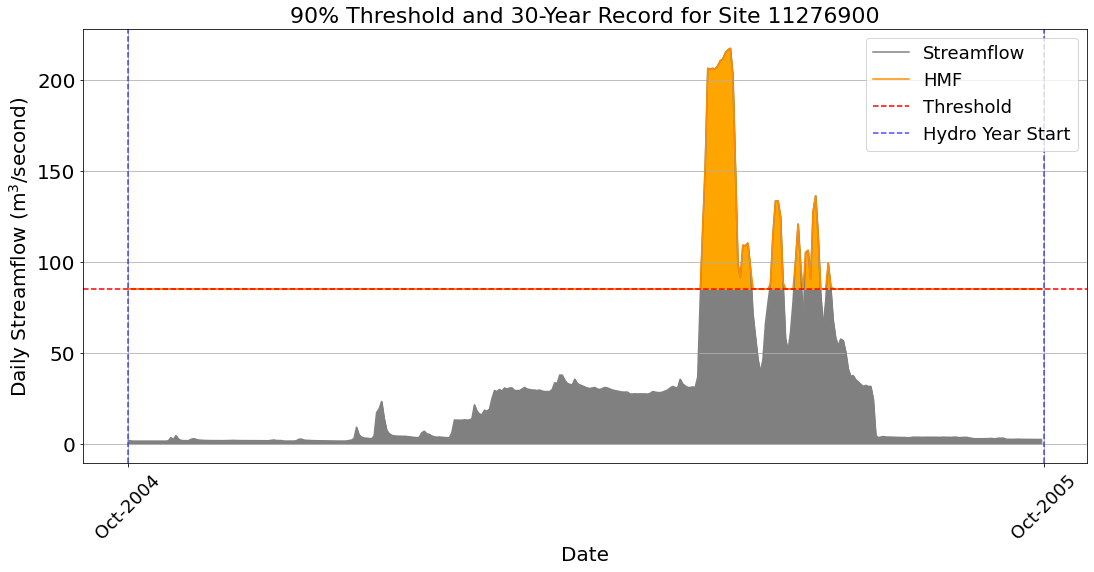

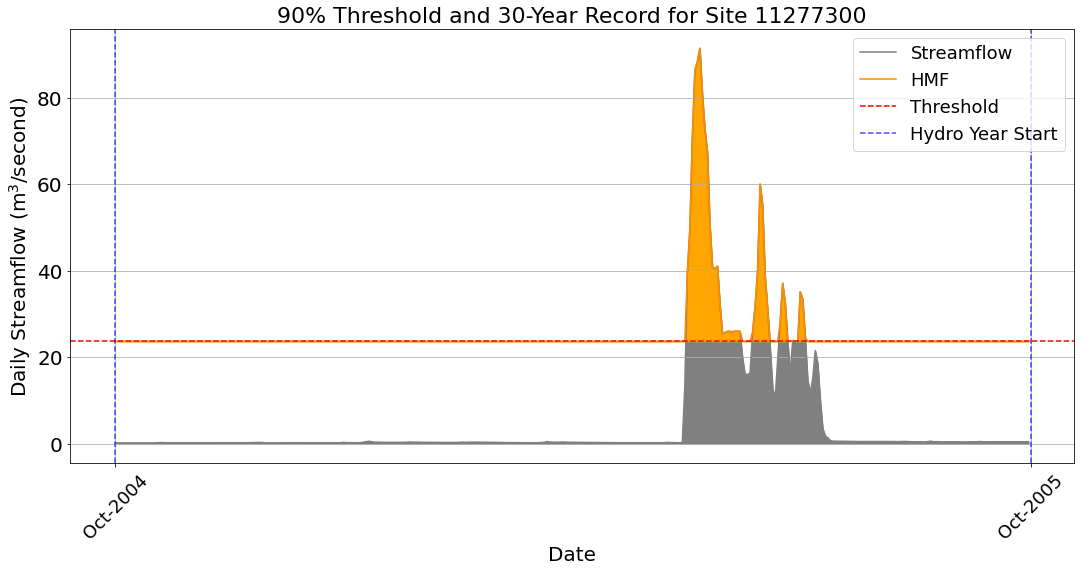

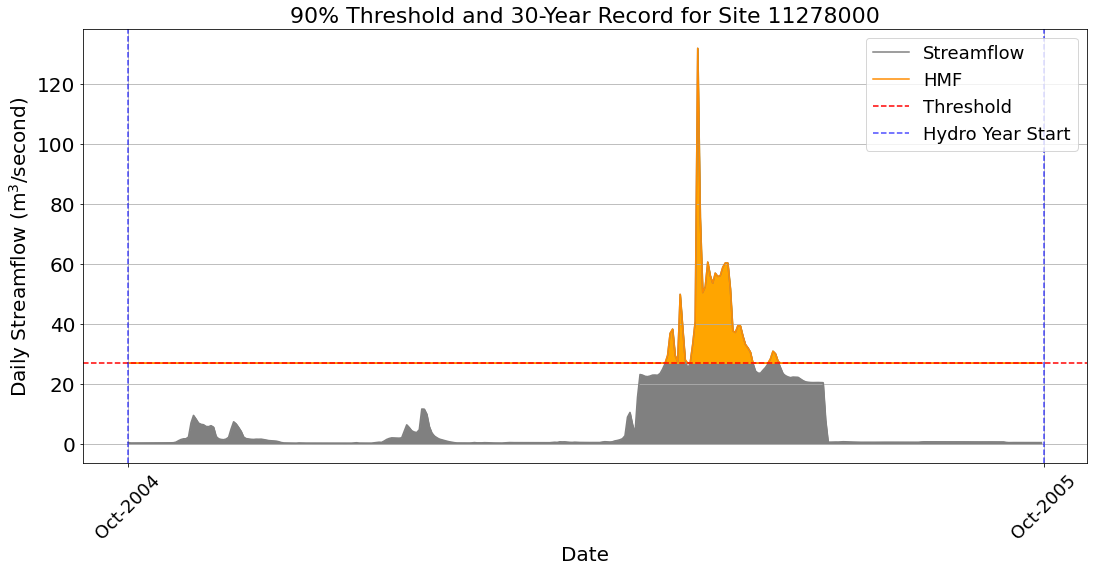

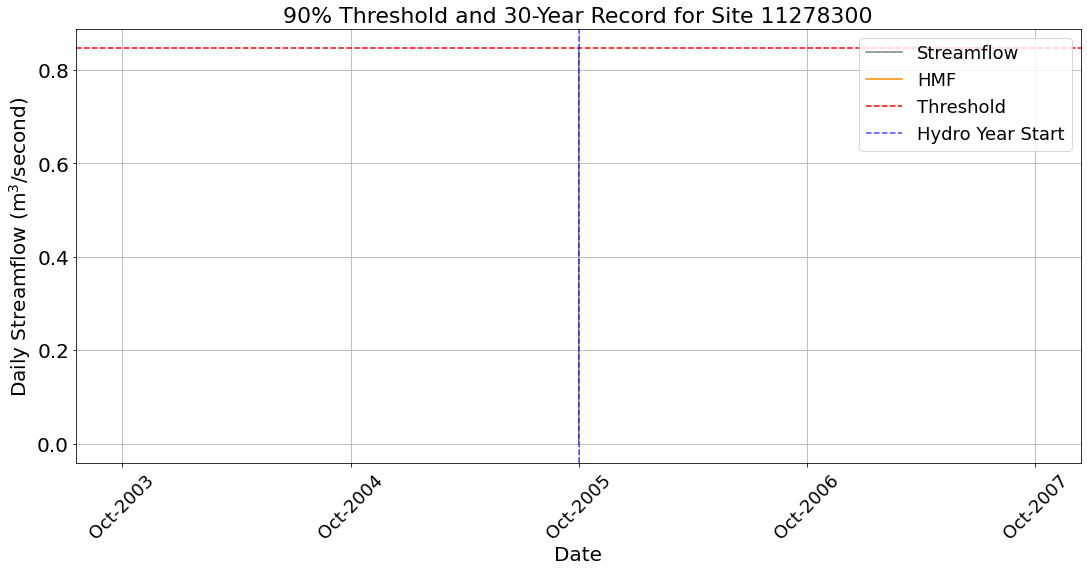

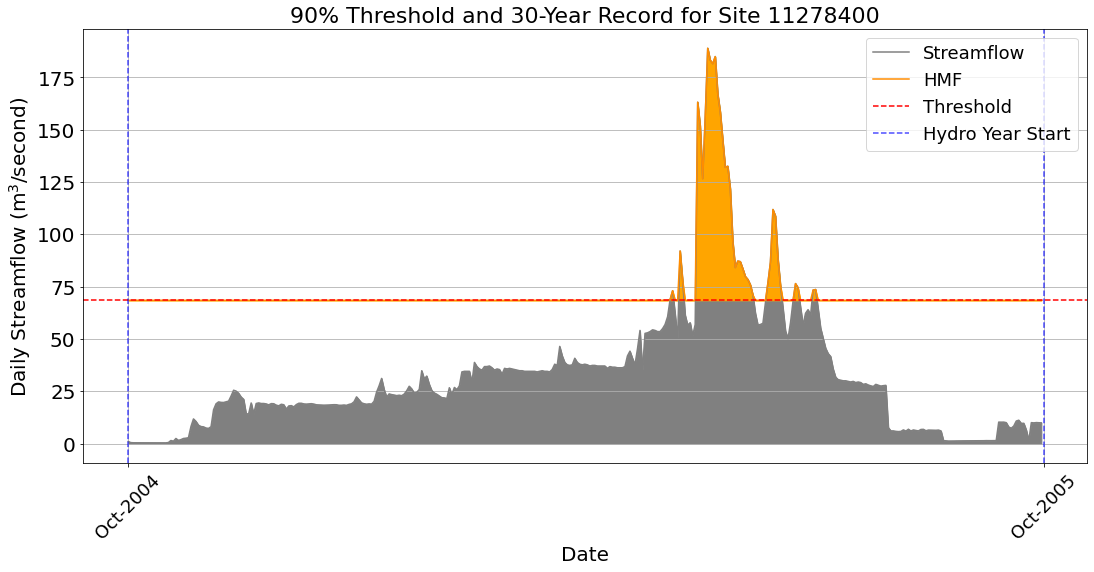

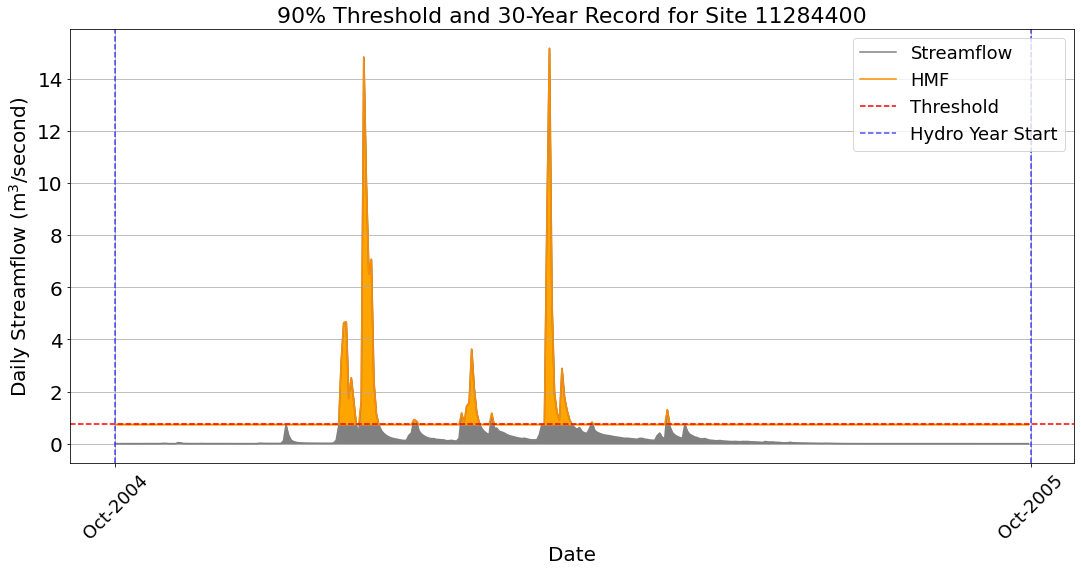

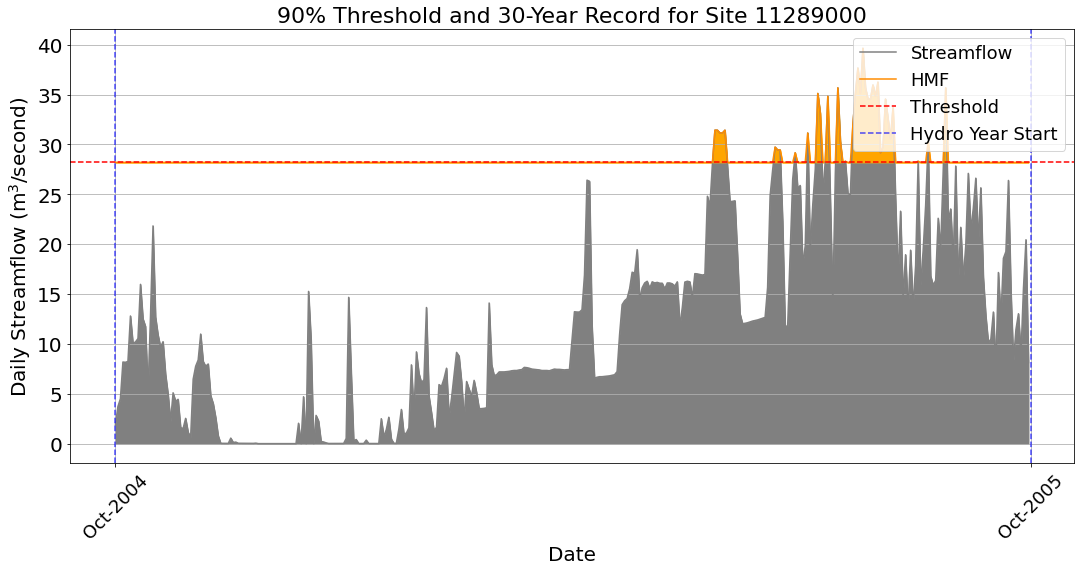

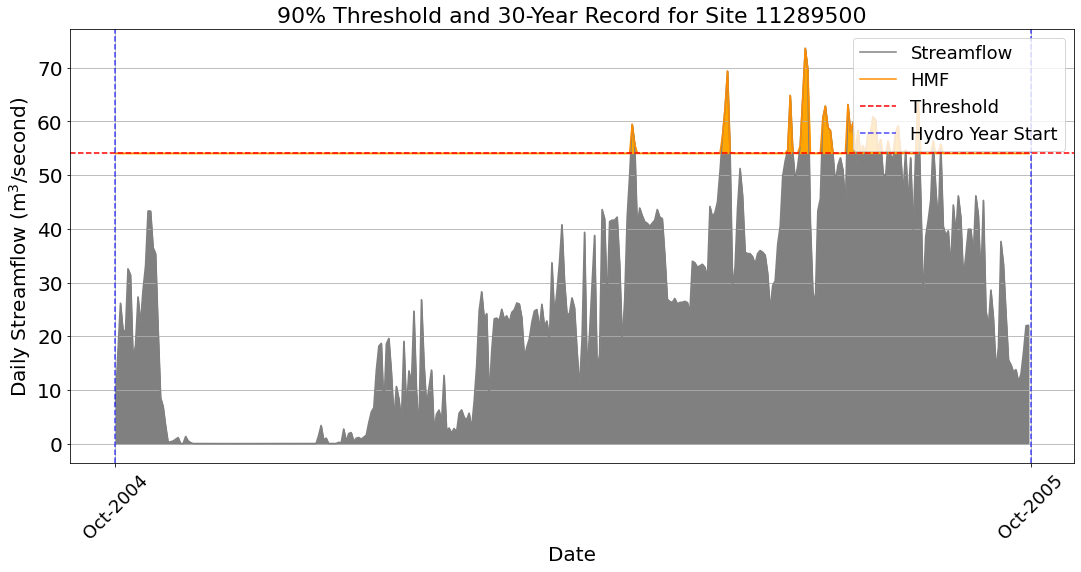

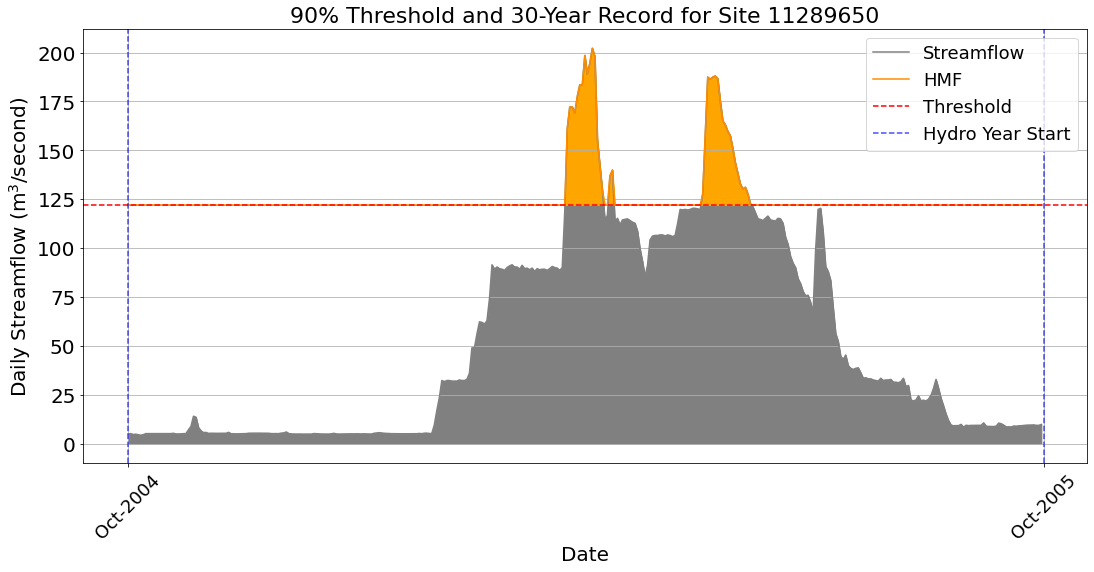

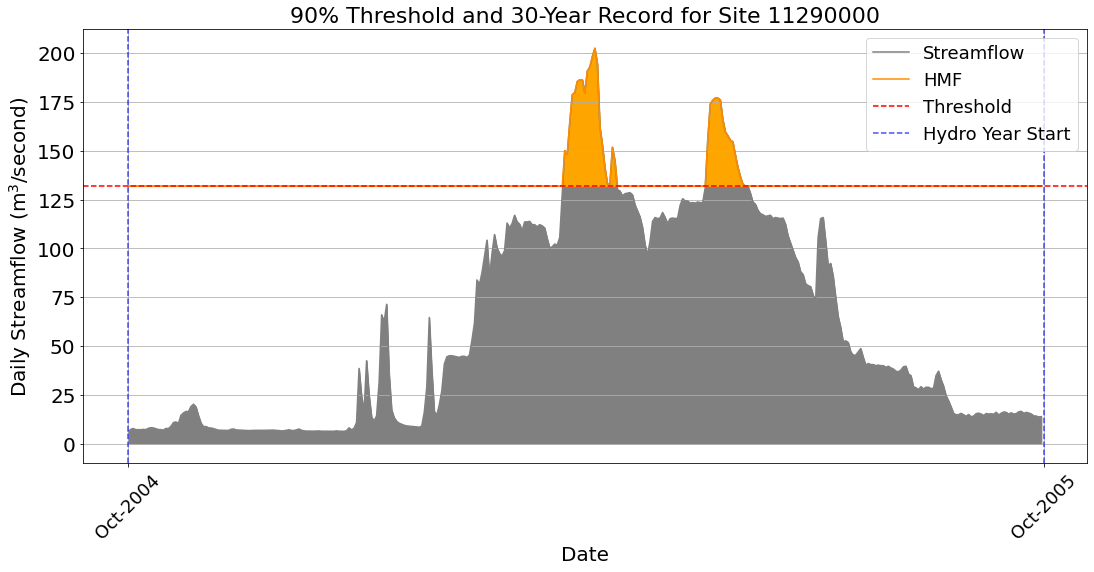

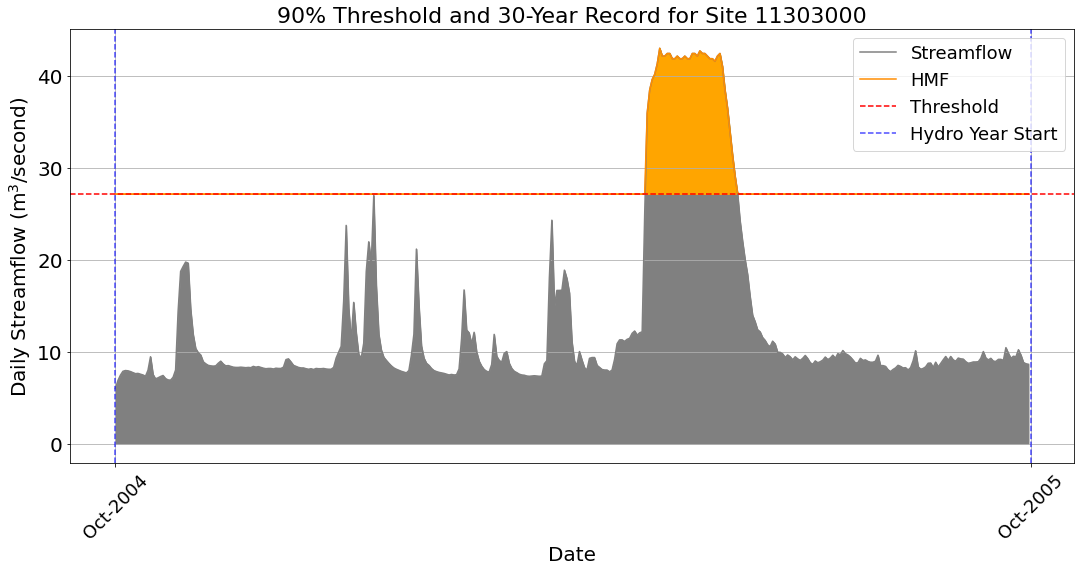

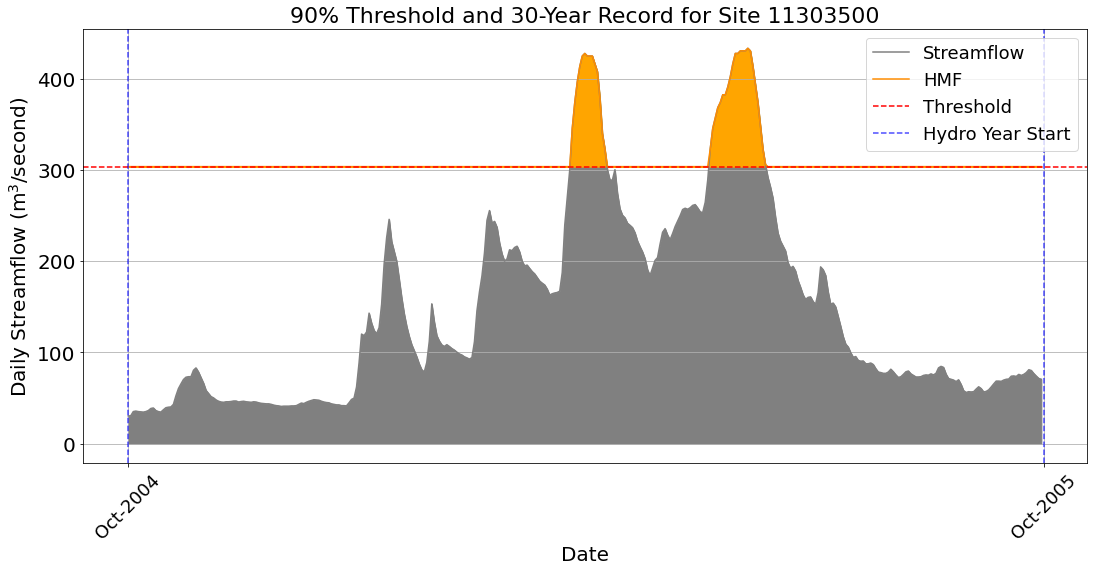

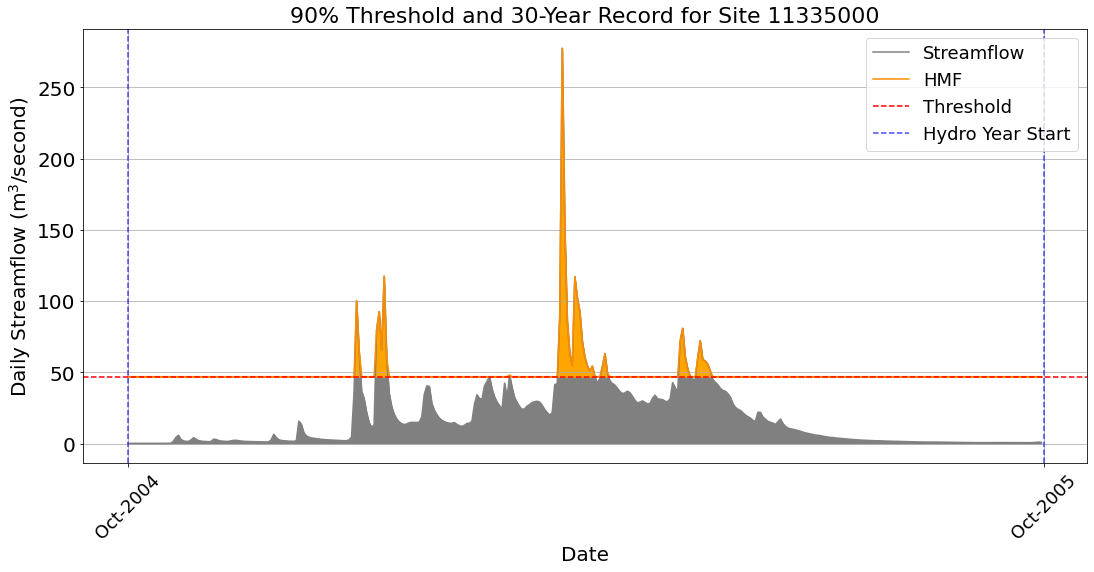

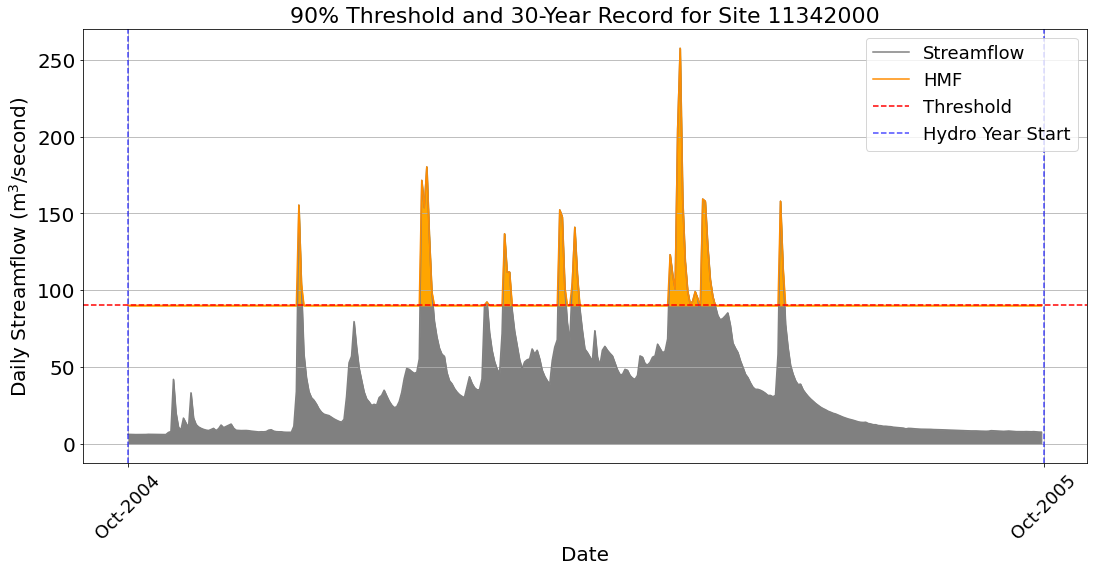

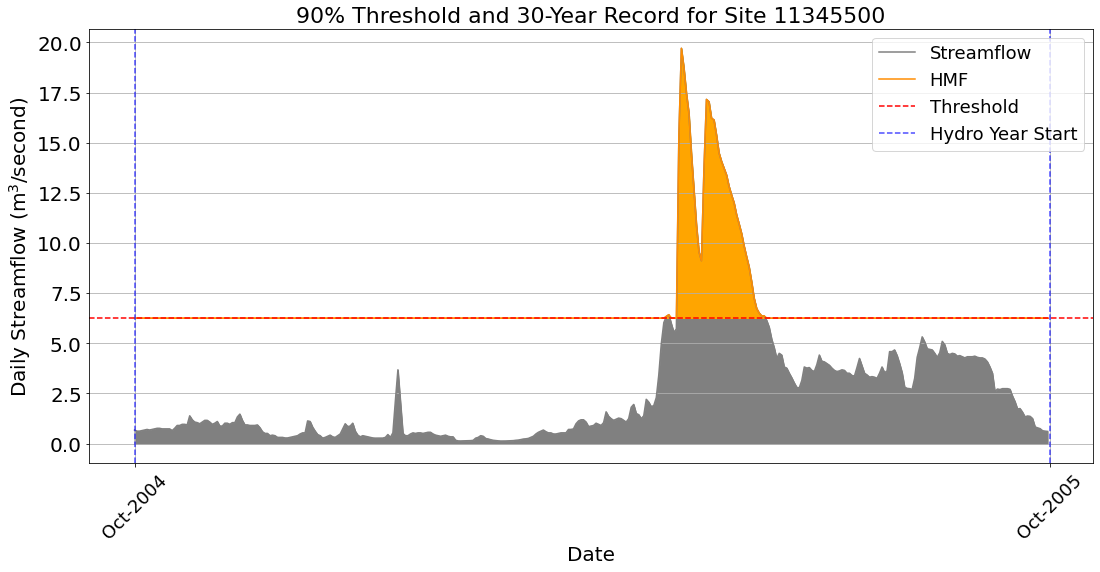

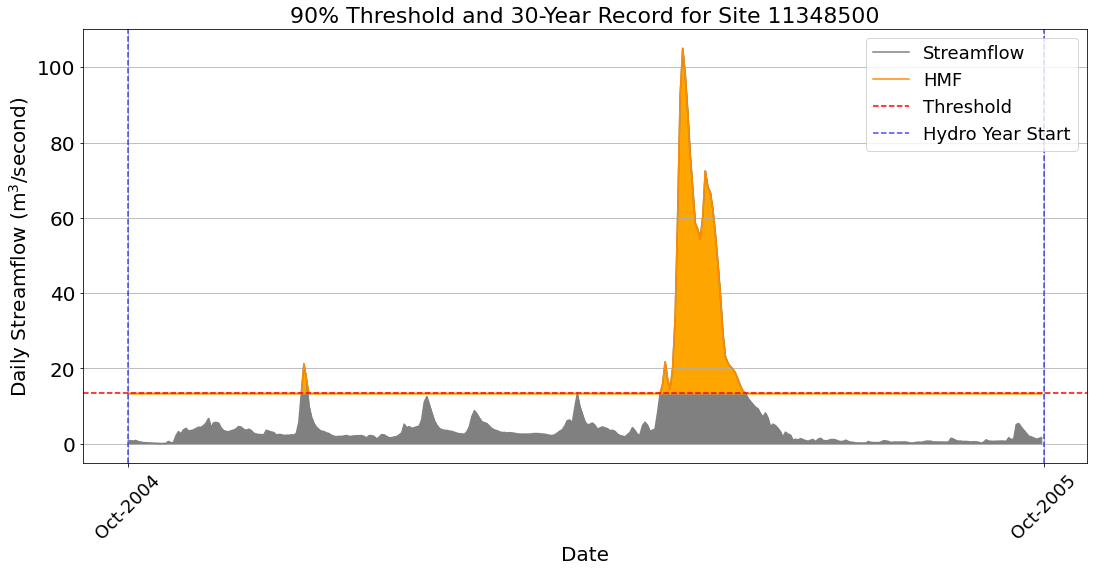

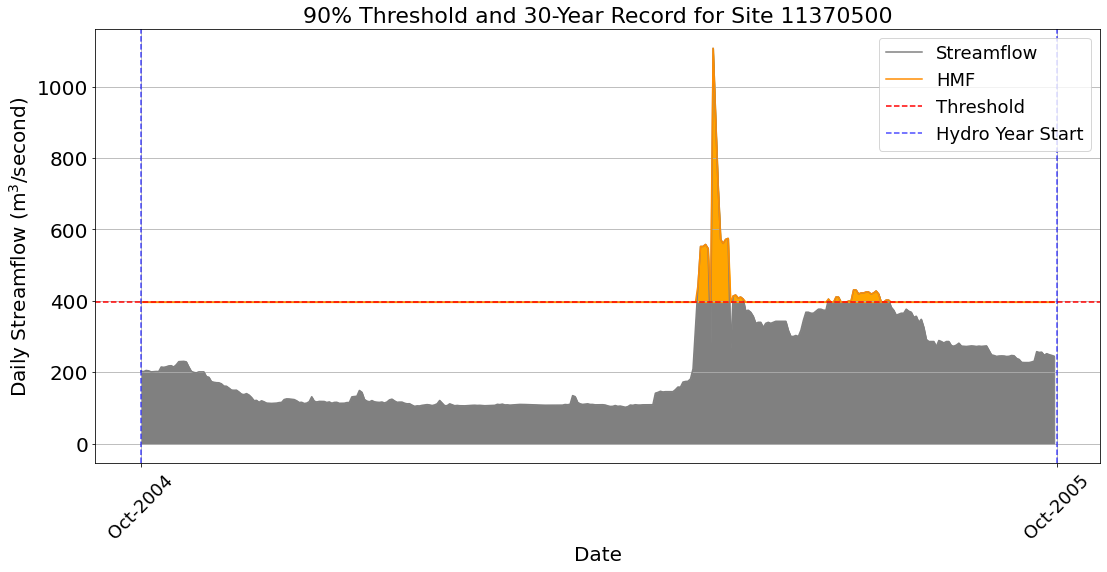

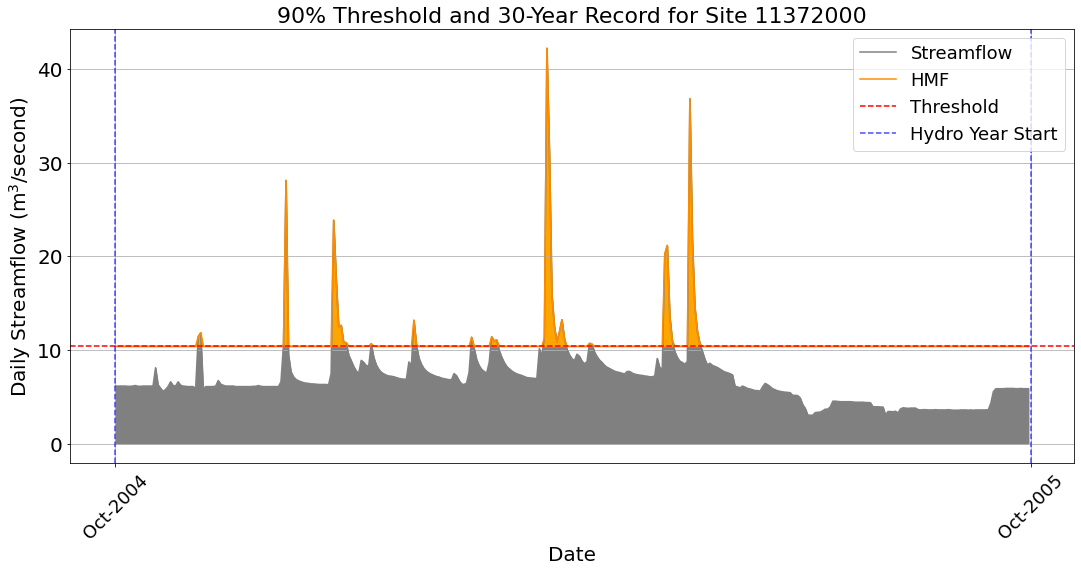

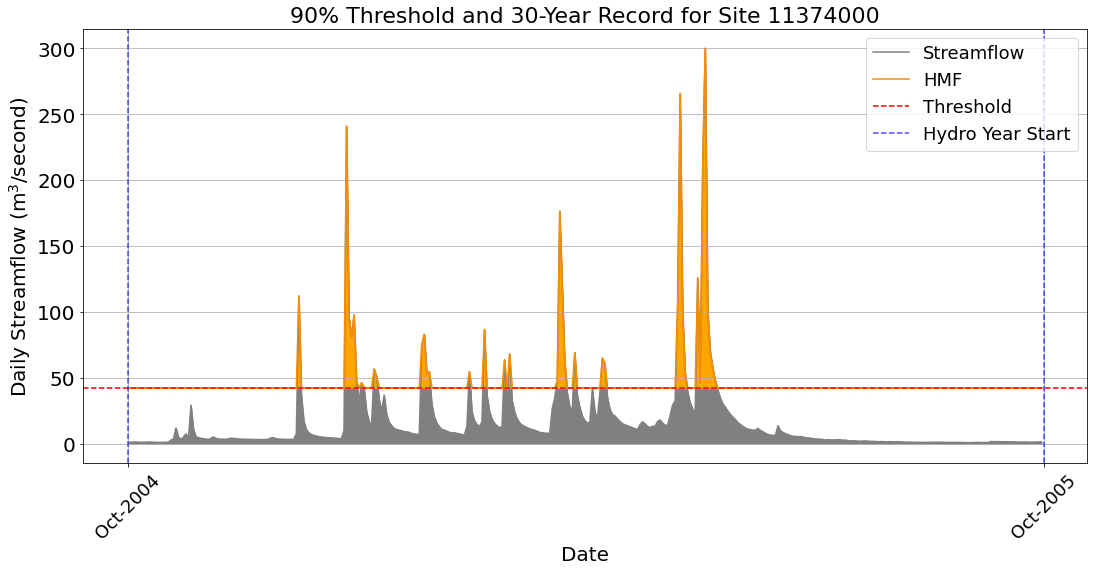

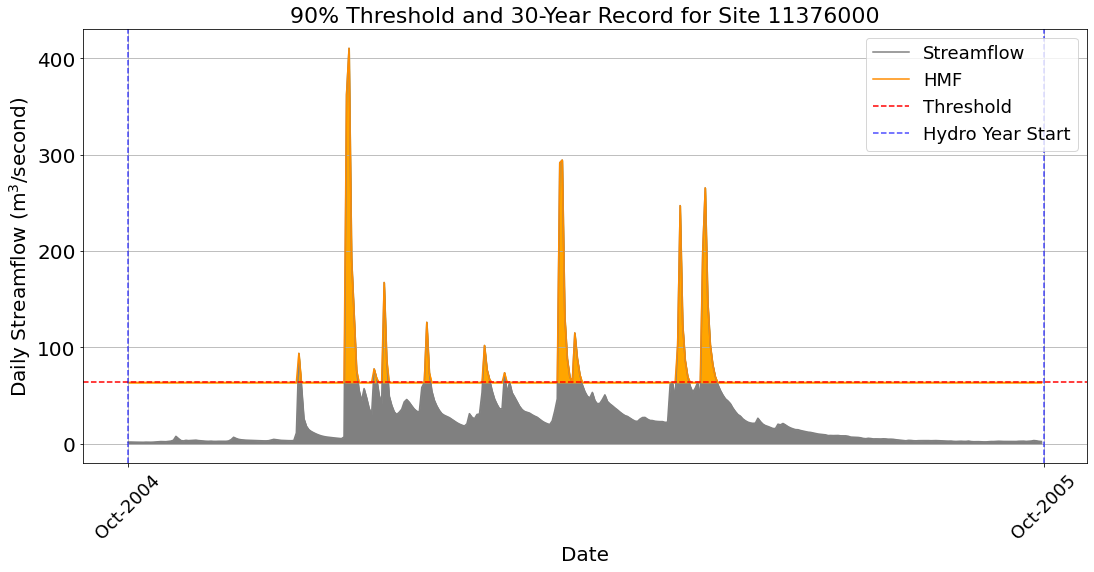

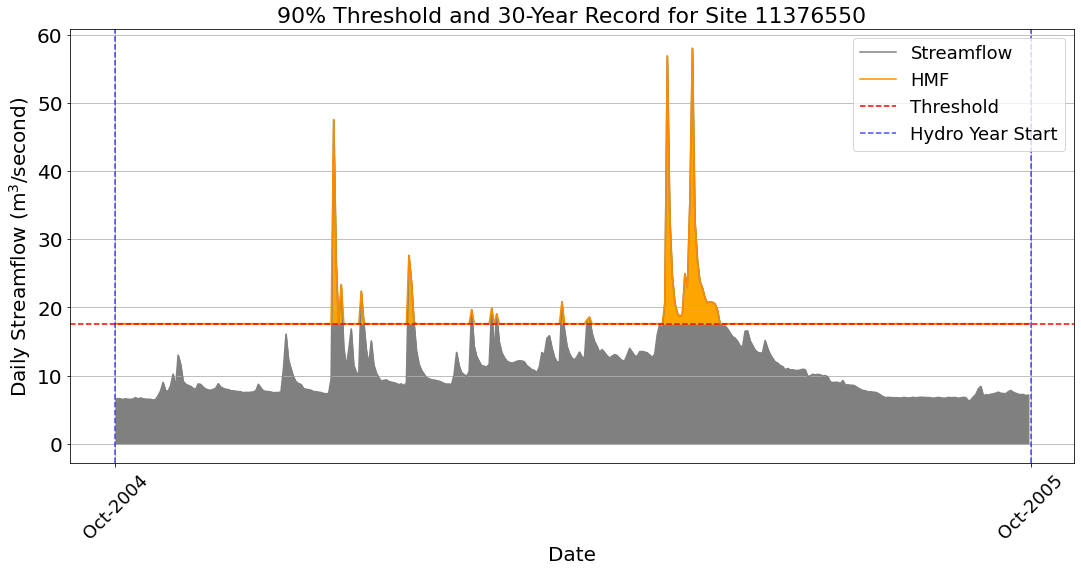

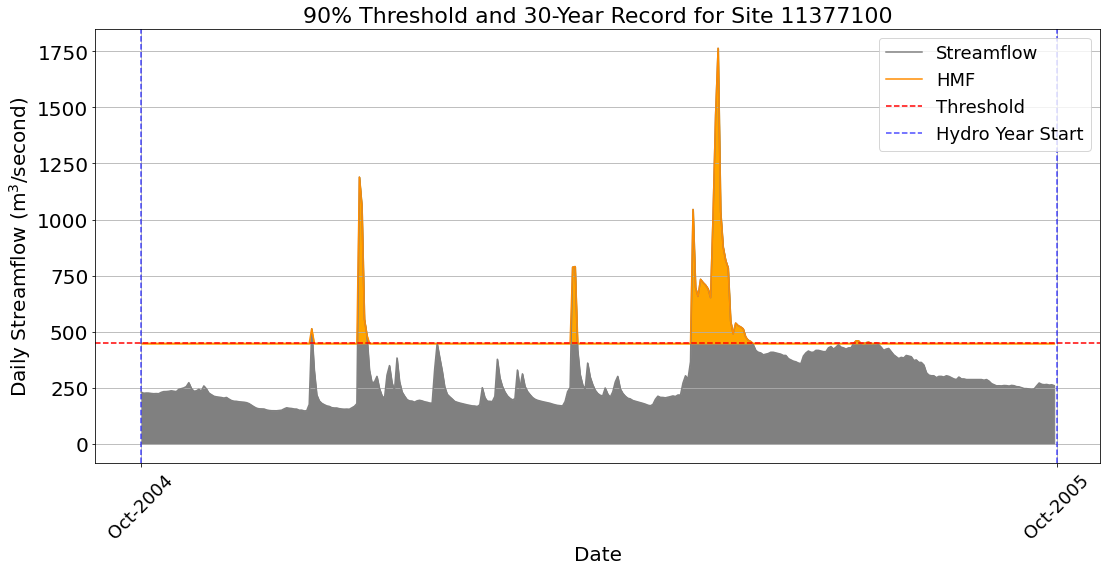

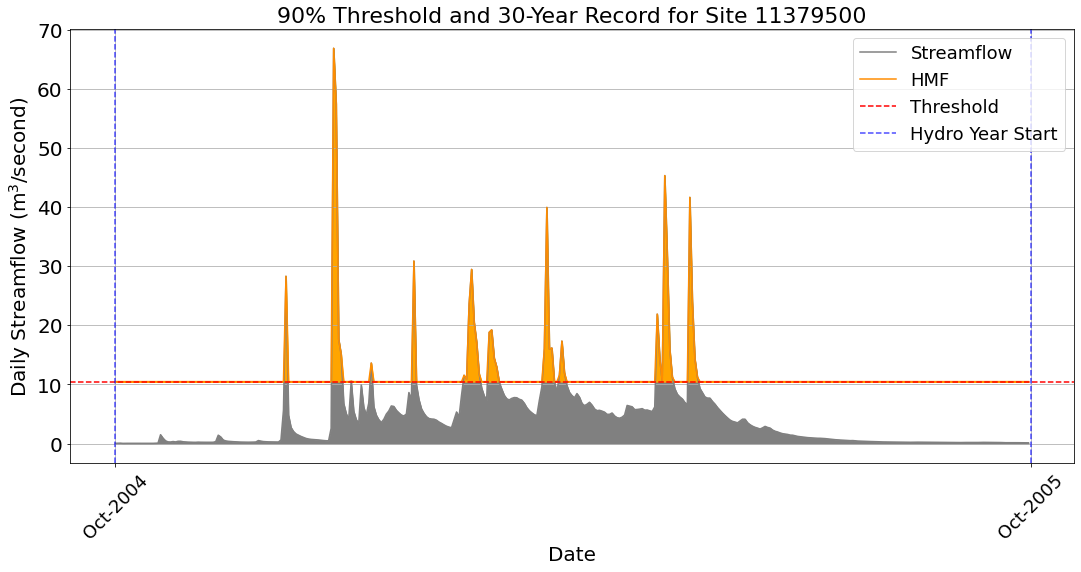

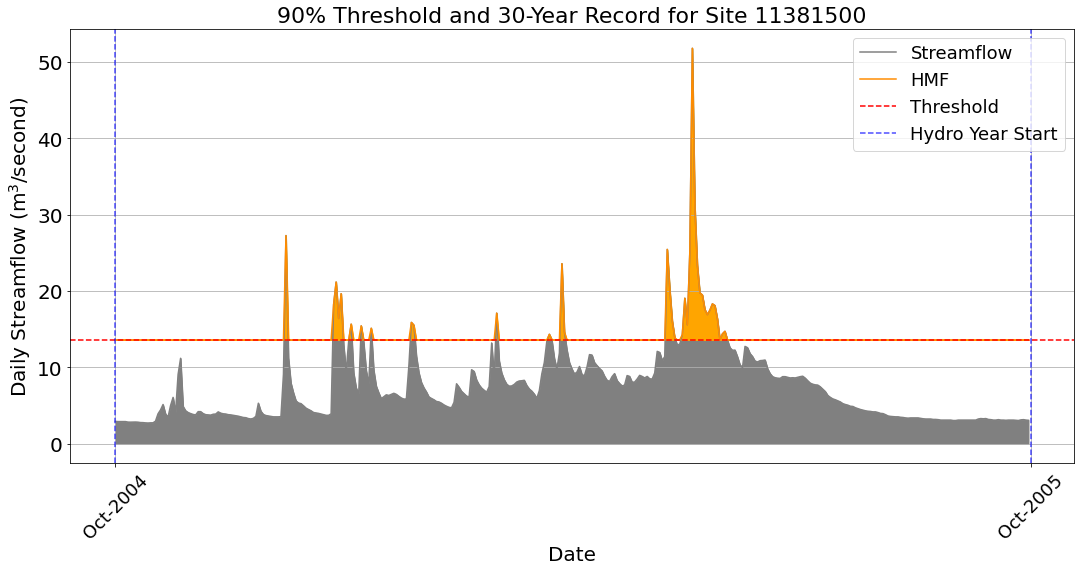

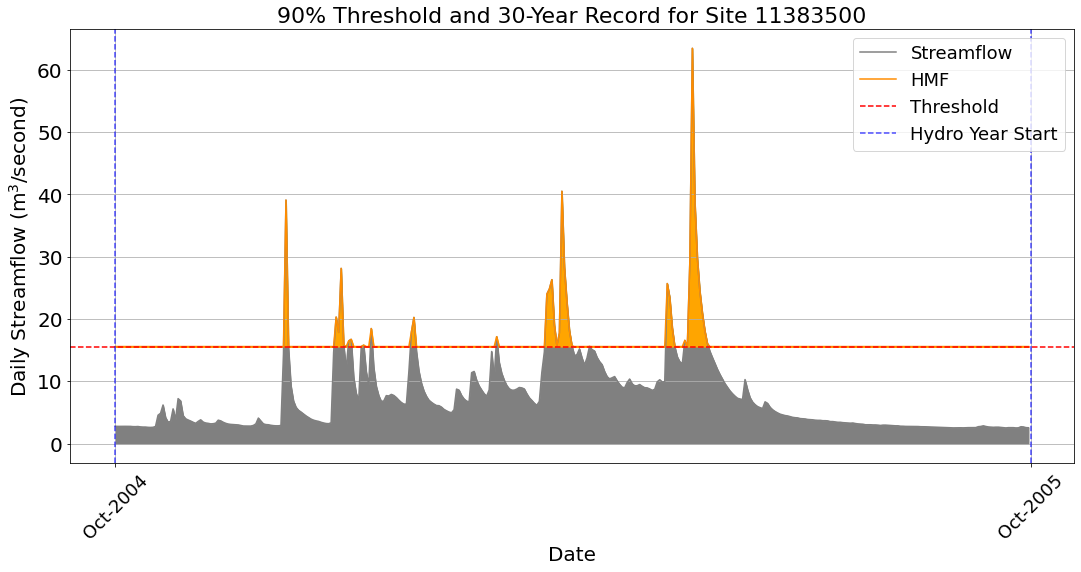

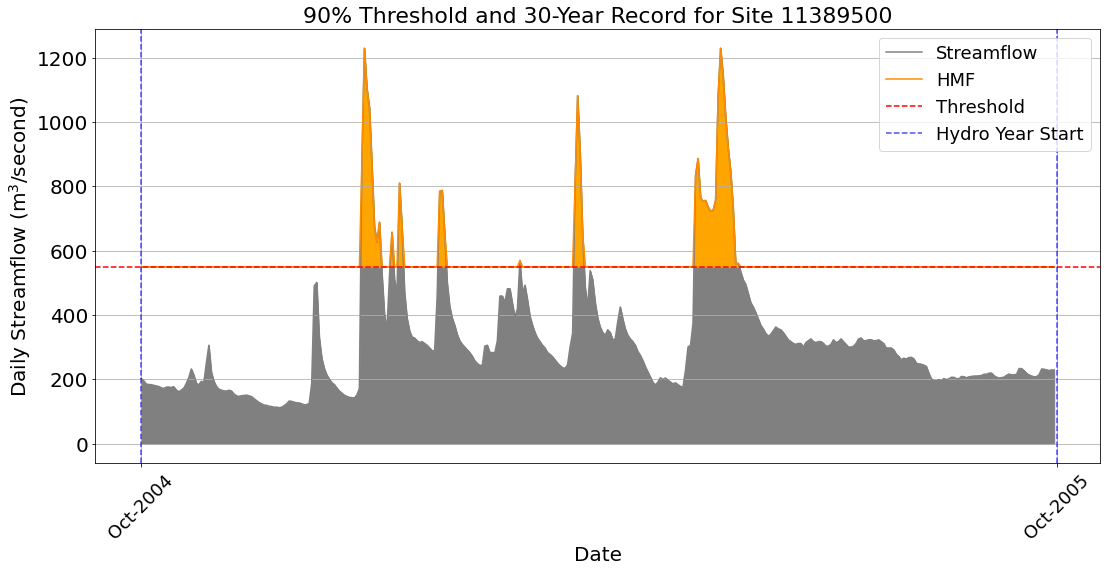

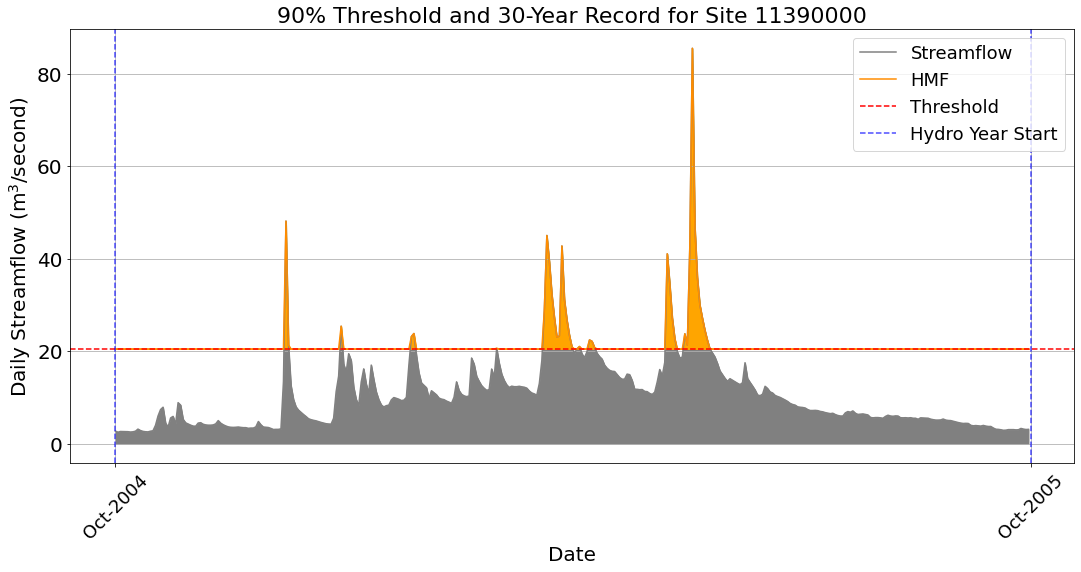

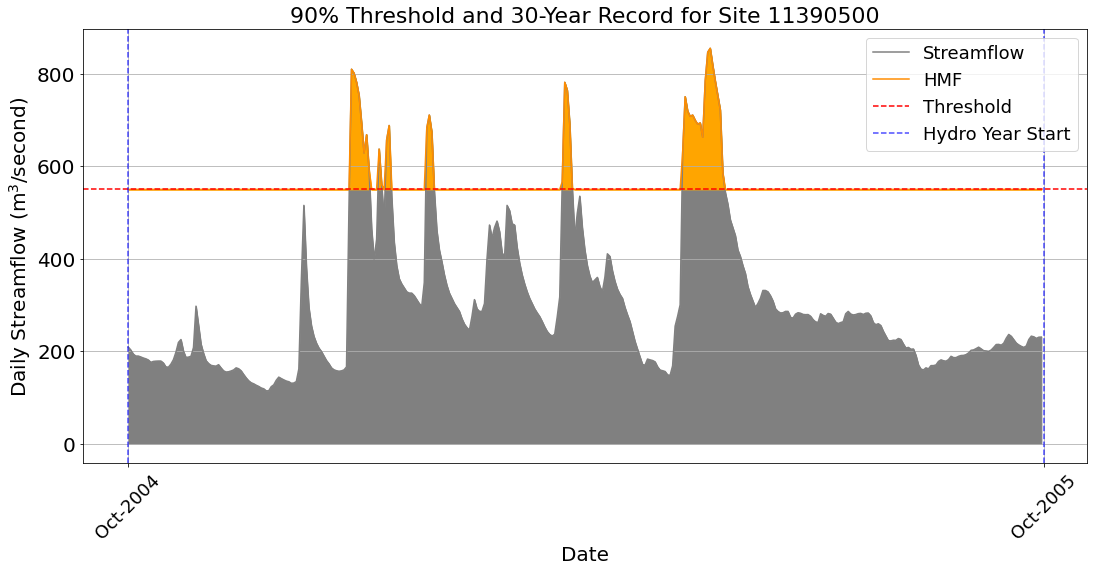

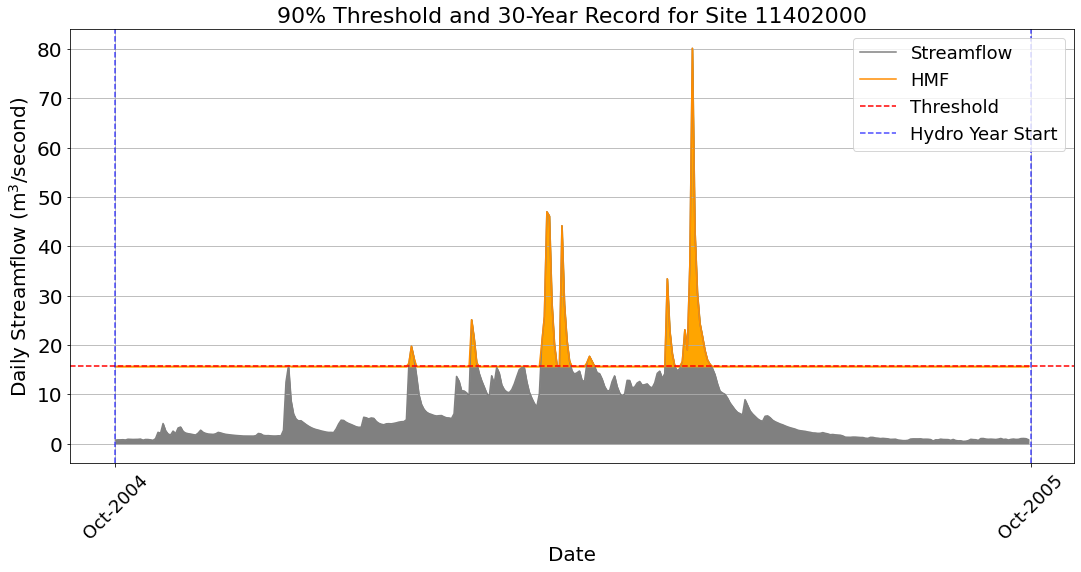

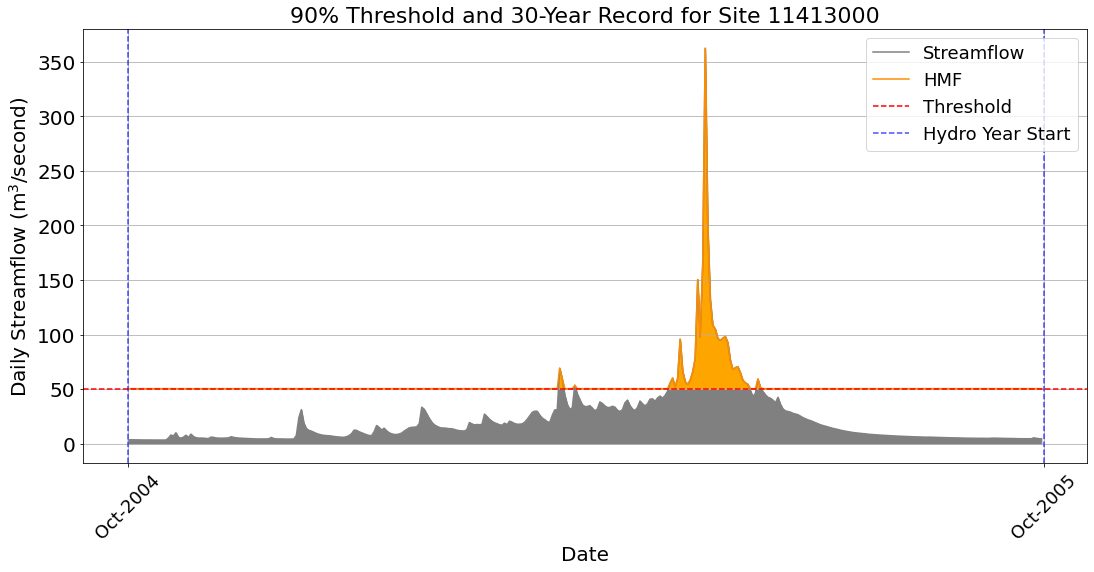

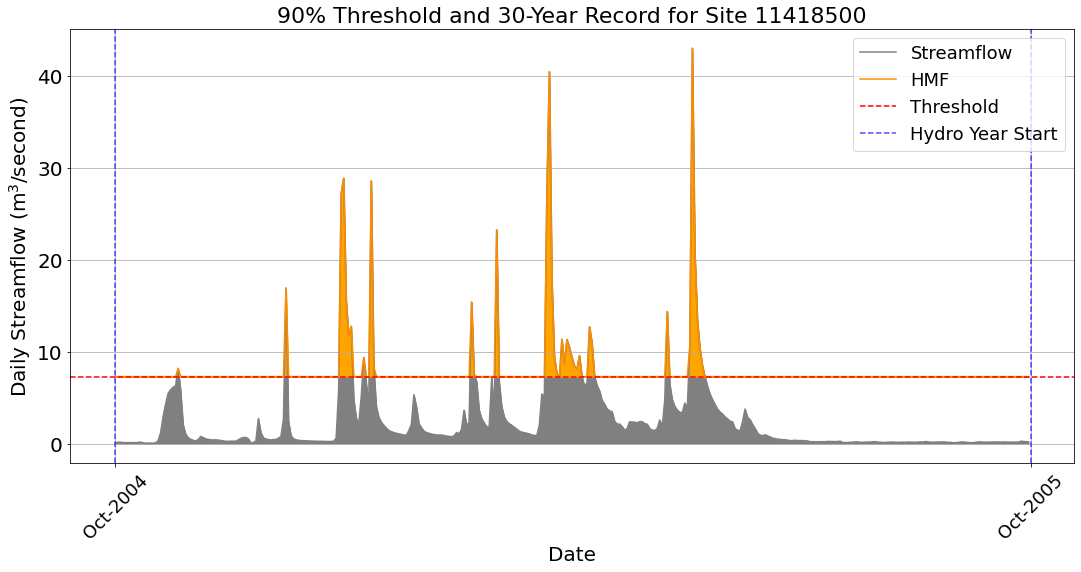

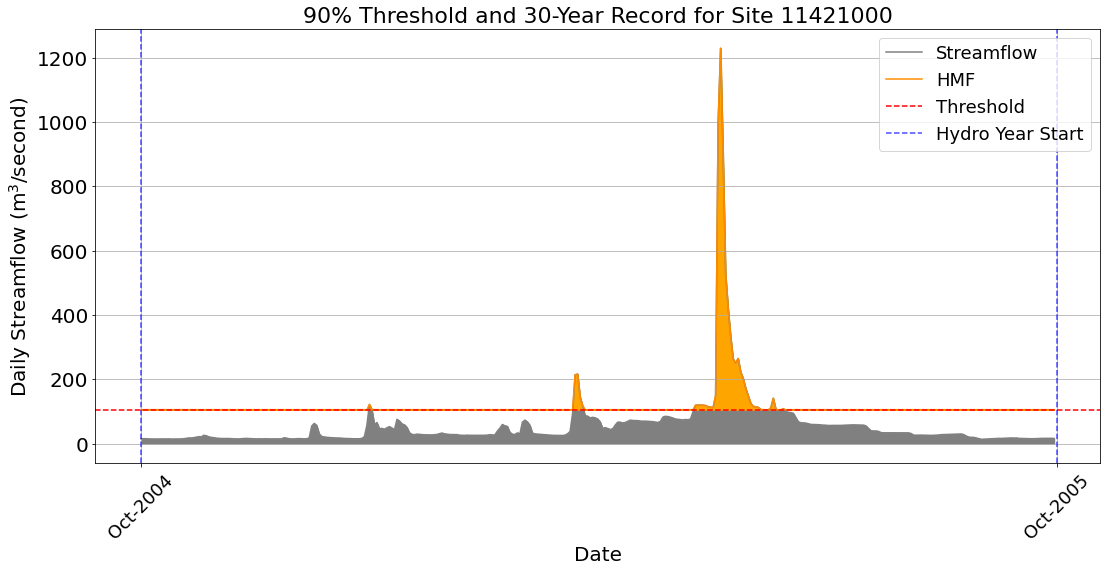

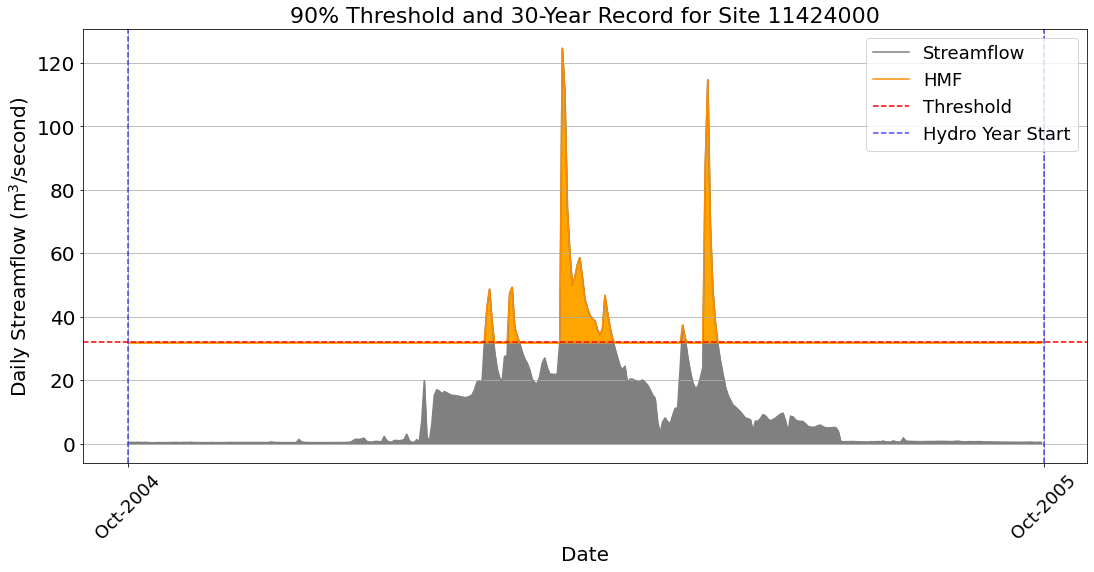

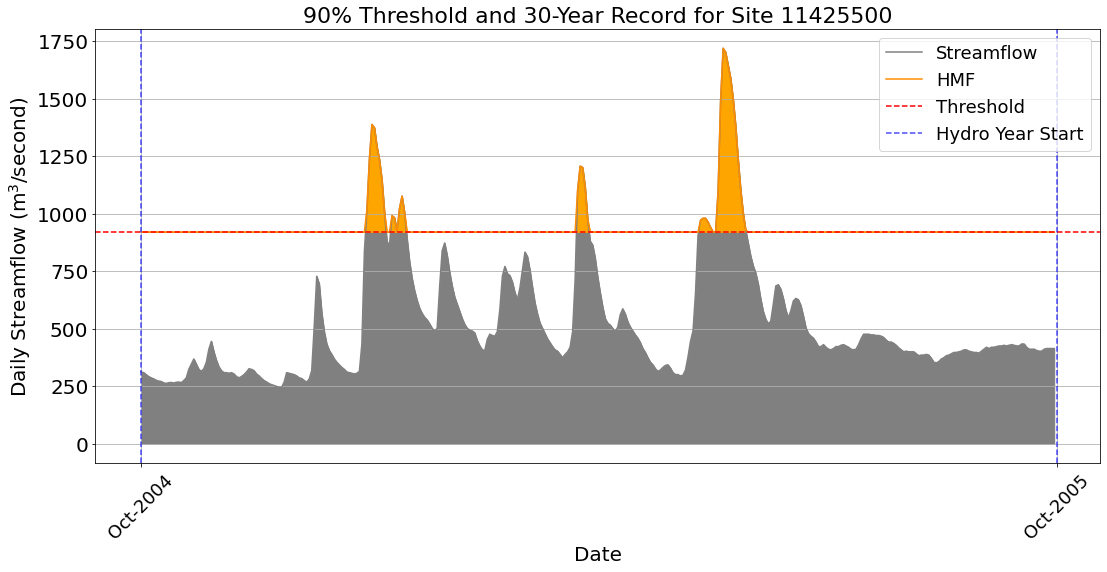

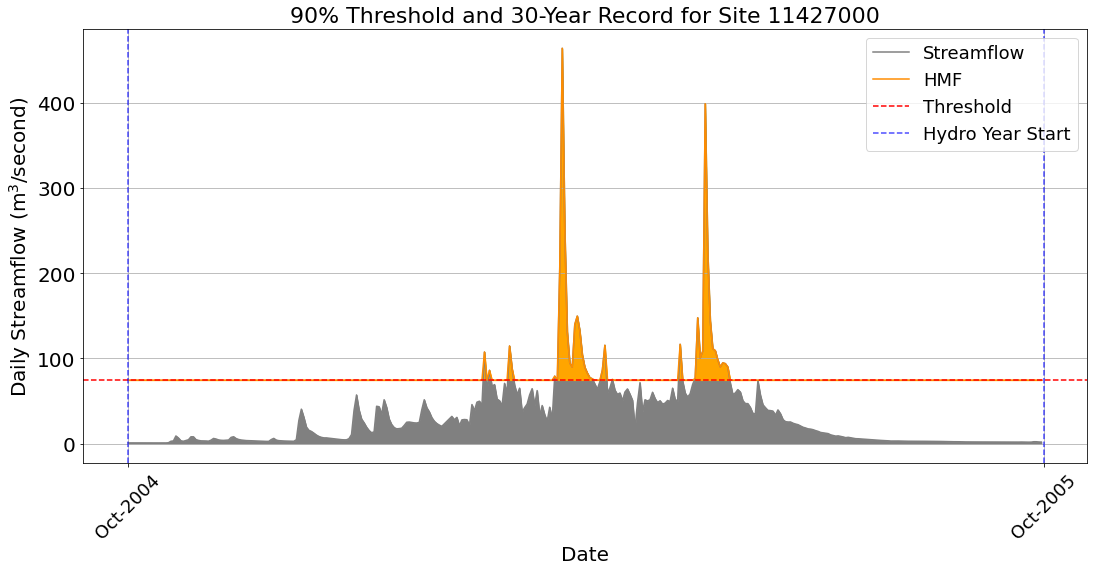

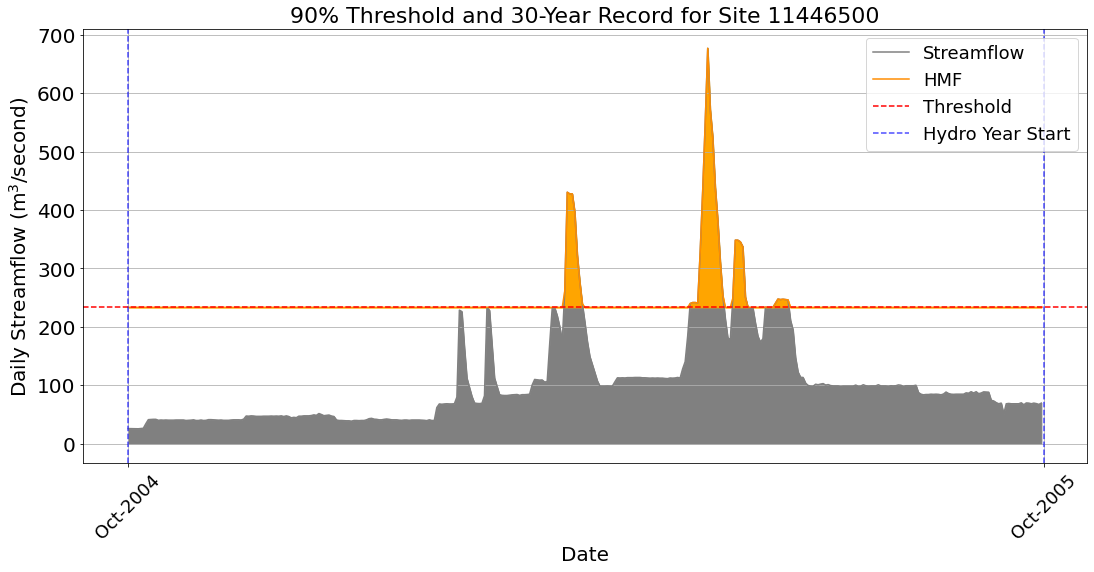

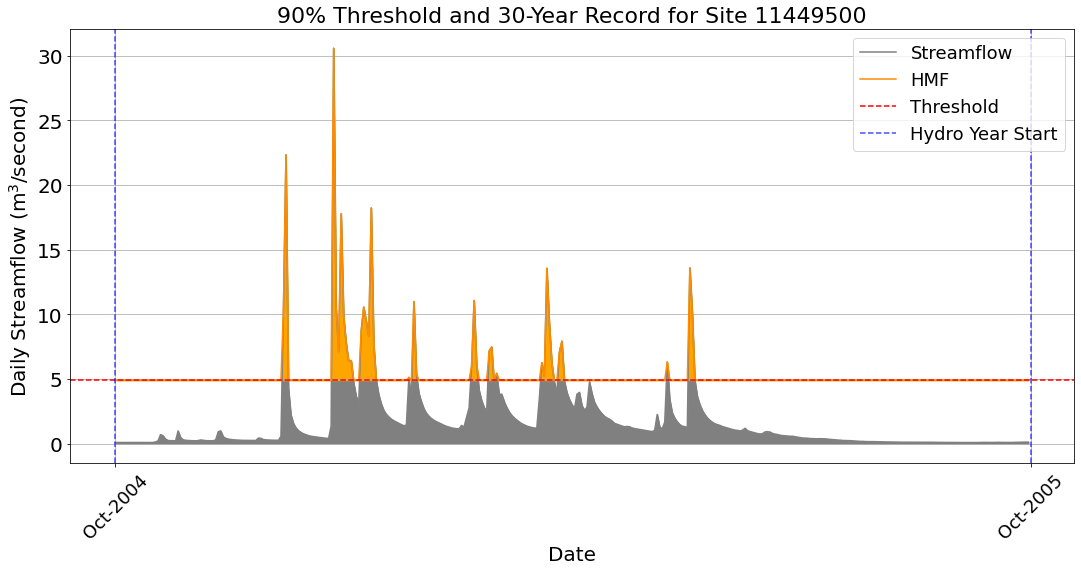

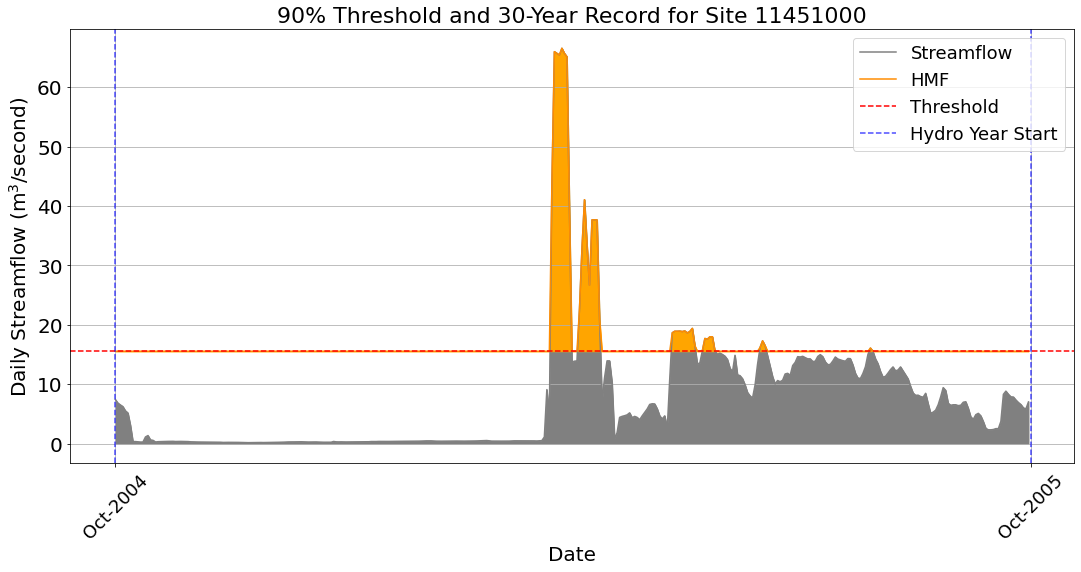

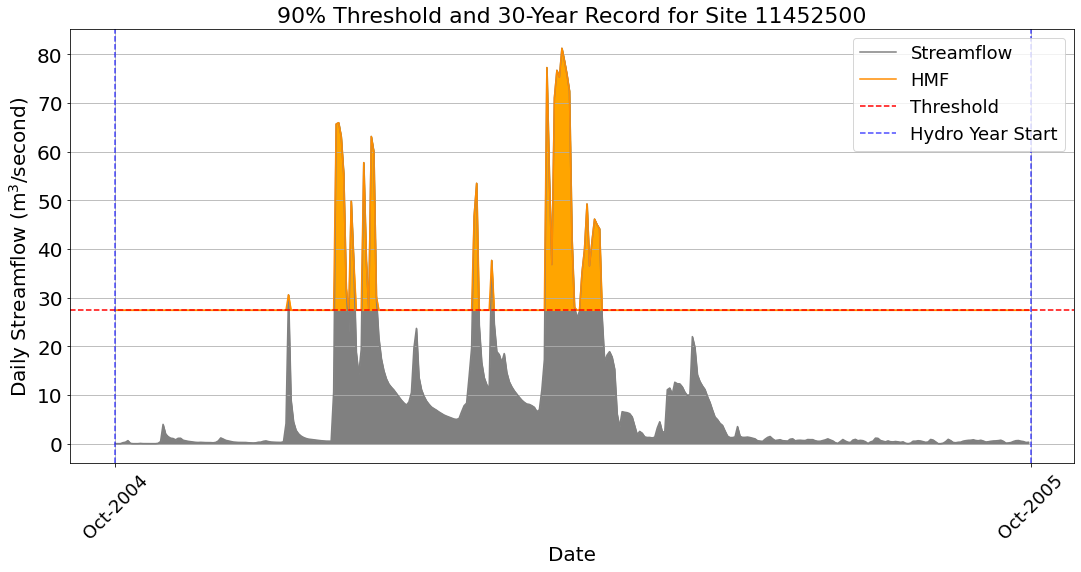

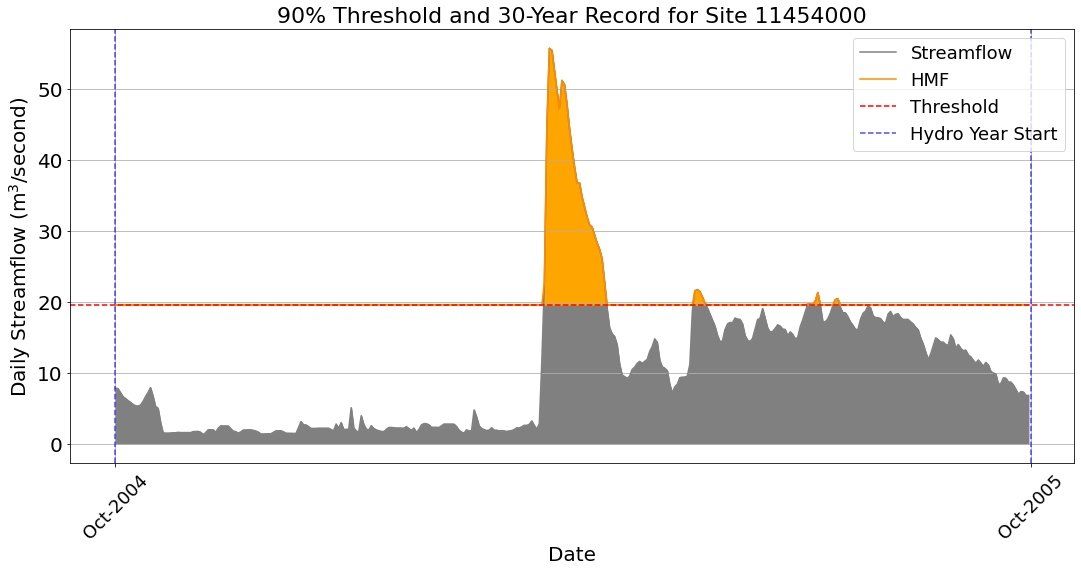

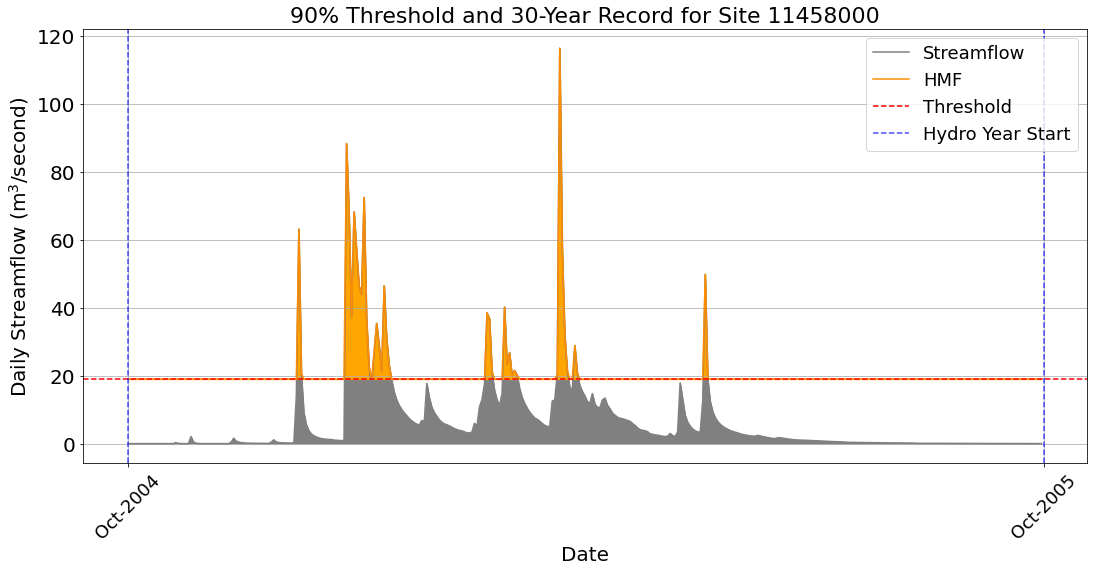

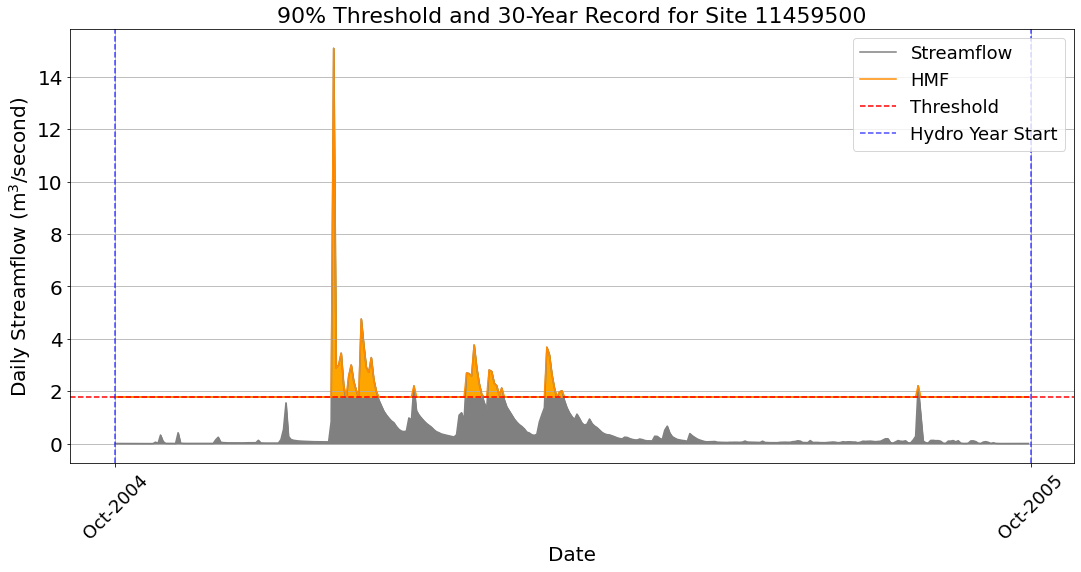

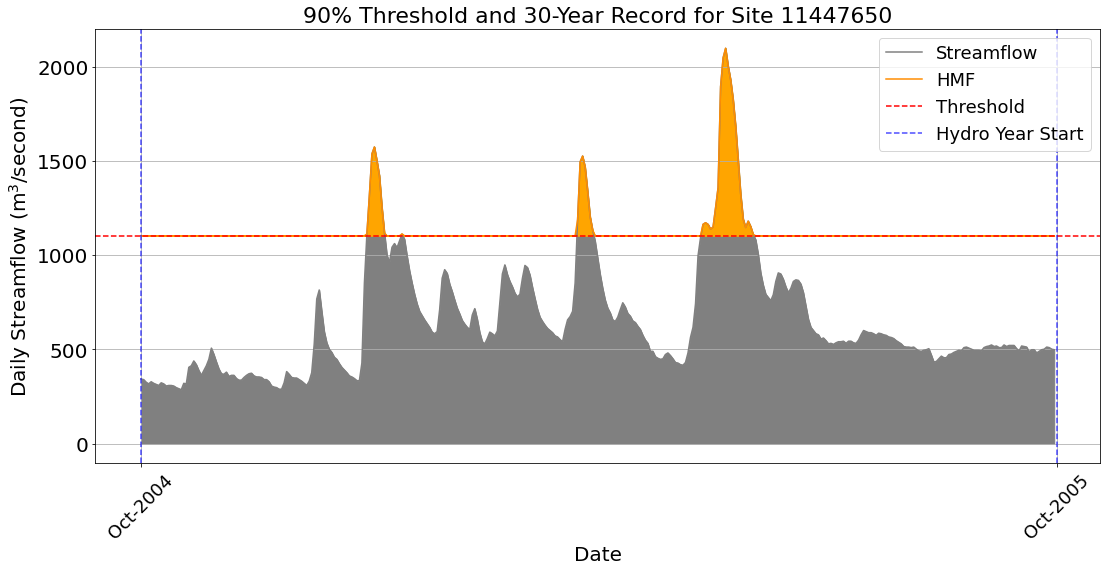

In [200]:
DEFAULT_START = '2004-10-01'
DEFAULT_END = '2005-09-30' # end date for this study

PLOT_START = '1990-10-01'
PLOT_END = '2020-10-01'
CFS_TO_CMS = 0.028316846592

for site_no in sites_cv:
    df = nwis.get_record(sites=str(site_no), service=fn.SERVICE, parameterCD=fn.PARAM_CODE, start=DEFAULT_START, end=DEFAULT_END)
    streamflow_timeseries(df, PLOT_START, PLOT_END, False)

In [188]:
sites_cv    

[11162500,
 11162630,
 11164500,
 11169500,
 11176400,
 11176500,
 11176900,
 11179000,
 11180500,
 11180700,
 11181040,
 11182500,
 11189500,
 11200800,
 11224500,
 11251000,
 11253310,
 11264500,
 11266500,
 11274000,
 11274500,
 11274630,
 11276500,
 11276600,
 11276900,
 11277300,
 11278000,
 11278300,
 11278400,
 11284400,
 11289000,
 11289500,
 11289650,
 11290000,
 11303000,
 11303500,
 11335000,
 11342000,
 11345500,
 11348500,
 11370500,
 11372000,
 11374000,
 11376000,
 11376550,
 11377100,
 11379500,
 11381500,
 11383500,
 11389500,
 11390000,
 11390500,
 11402000,
 11413000,
 11418500,
 11421000,
 11424000,
 11425500,
 11427000,
 11446500,
 11449500,
 11451000,
 11452500,
 11454000,
 11458000,
 11459500,
 11447650]